In [116]:
import pandas as pd
import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import metapredict as meta
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')
sns.set_context('talk')


In [117]:
cc_names = pd.read_excel("../data/gene_names_with_location_and_pmvs.xlsx")
cc_names = cc_names.rename(columns = {"gene" : "Gene", "start" : "Start", "end" : "End"})
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
cc_names = pd.merge(known_ADs[["uniprotID", "Gene", "Start", "End"]], cc_names)
ensts = pd.read_csv("../data/SFARI_TFs_with_ENST_corrected.csv", index_col = 0)
cc_names = pd.merge(cc_names, ensts)
cc_names["ENST"] = cc_names["ENST"].str.split(".").str[0]
cc_names

uniprotID    Gene  Start   End  pMVS #   Gene Name             ENST
0     O94983  CAMTA2    285   468     404  CAMTA2_AD1  ENST00000348066
1     O94983  CAMTA2    472   581     405  CAMTA2_AD2  ENST00000348066
2     P11308     ERG    433   479     400     ERG_AD1  ENST00000288319
3     P11308     ERG    118   261     406     ERG_AD2  ENST00000288319
4     Q13422   IKZF1    284   365     402    IKZF1_AD  ENST00000331340
5     O14770   MEIS2    340   477     377    MEIS2_AD  ENST00000561208
6     Q15788   NCOA1   1241  1385     379   NCOA1_AD2  ENST00000348332
7     Q15788   NCOA1    840  1011     380   NCOA1_AD3  ENST00000348332
8     O95096  NKX2-2    220   273     381   NKX2-2_AD  ENST00000377142
9     P43354   NR4A2      1    91     382   NR4A2_AD1  ENST00000339562
10    P43354   NR4A2    584   598     383   NR4A2_AD2  ENST00000339562
11    P32242    OTX1    172   354     407     OTX1_AD  ENST00000282549
12    Q02548    PAX5    304   358     410     PAX5_AD  ENST00000358127
13    P26367    PAX6    271   422     403     PAX6_AD  ENST00000241001
14    P78337   PITX1    234   283     409    PITX1_AD  ENST00000265340

In [118]:
i =1
for ENST in set(cc_names["ENST"]):
    print(ENST)
    # query = 'track type=bigWig logo=on name="Zoonomia' + str(i) + '" description="Zoonomia" visibility=full autoScale=off bigDataUrl=track type=bigWig logo=on name="Zoonomia3" description="Zoonomia" visibility=full autoScale=off bigDataUrl=https://cgl.gi.ucsc.edu/data/cactus/241-mammalian-2020v2-hub/Homo_sapiens/241-mammalian-2020v2.bigWig\nbrowser position ' + ENST
    # i+=1
    # print(query)
    # print()

ENST00000331340
ENST00000282549
ENST00000241001
ENST00000339562
ENST00000358127
ENST00000265340
ENST00000348066
ENST00000377142
ENST00000348332
ENST00000288319
ENST00000561208


Ignore below, all actually done for 100 vertebrates dataset instead of zoonomia

- File paths incorrect
- Change before runninga gain

In [119]:
verteb_output_paths = glob.glob("../data/100_verteb/*")
verteb = []


def df_ENST(ENST):
    df = pd.read_csv('../data/100_verteb/' + ENST + '.tsv', sep = '\t')
    df["chrom"] = df.columns[0]
    df["chrom"] = df["chrom"].str.split('"').str[1].str.split("chr").str[1].astype(int)
    df = df.drop(columns = df.columns[0]).reset_index().rename(columns = {"level_2" : "PhyloP", 
                                                                         "level_0" : "start",
                                                                         "level_1" : "end"})
    df = df[["chrom", "start", "end", "PhyloP"]]
    return df


for z in verteb_output_paths:
    ENST = z.split("/")[-1].split(".")[0]
    verteb.append(df_ENST(ENST))
verteb = pd.concat(verteb)
verteb = verteb.reset_index(drop = True)
verteb

chrom     start       end    PhyloP
0          20  21513171  21513172 -1.348490
1          20  21513172  21513173 -0.534118
2          20  21513173  21513174  0.047575
3          20  21513174  21513175 -0.068764
4          20  21513175  21513176  0.280252
...       ...       ...       ...       ...
982939     11  31790647  31790648 -0.382843
982940     11  31790648  31790649 -1.743030
982941     11  31790649  31790650 -0.278213
982942     11  31790650  31790651 -0.173583
982943     11  31790651  31790652  0.349567

[982944 rows x 4 columns]

In [120]:
verteb["PhyloP_pos"] = np.abs(verteb["PhyloP"])
verteb

chrom     start       end    PhyloP  PhyloP_pos
0          20  21513171  21513172 -1.348490    1.348490
1          20  21513172  21513173 -0.534118    0.534118
2          20  21513173  21513174  0.047575    0.047575
3          20  21513174  21513175 -0.068764    0.068764
4          20  21513175  21513176  0.280252    0.280252
...       ...       ...       ...       ...         ...
982939     11  31790647  31790648 -0.382843    0.382843
982940     11  31790648  31790649 -1.743030    1.743030
982941     11  31790649  31790650 -0.278213    0.278213
982942     11  31790650  31790651 -0.173583    0.173583
982943     11  31790651  31790652  0.349567    0.349567

[982944 rows x 5 columns]

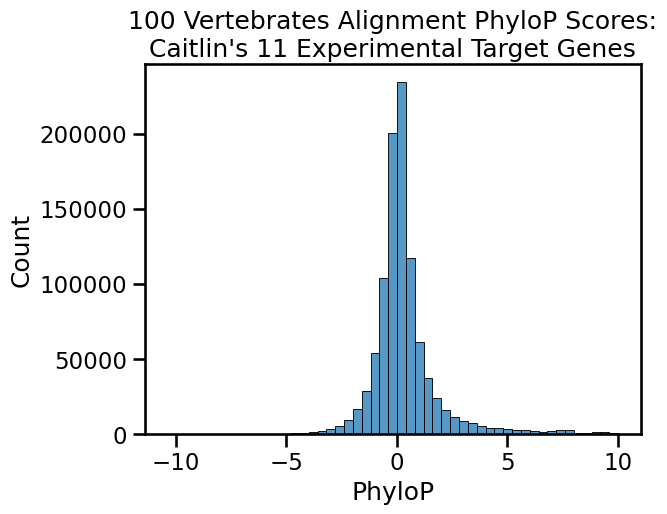

In [121]:
sns.histplot(verteb["PhyloP"], bins = 51);
plt.title("100 Vertebrates Alignment PhyloP Scores:\nCaitlin's 11 Experimental Target Genes");

<Axes: >

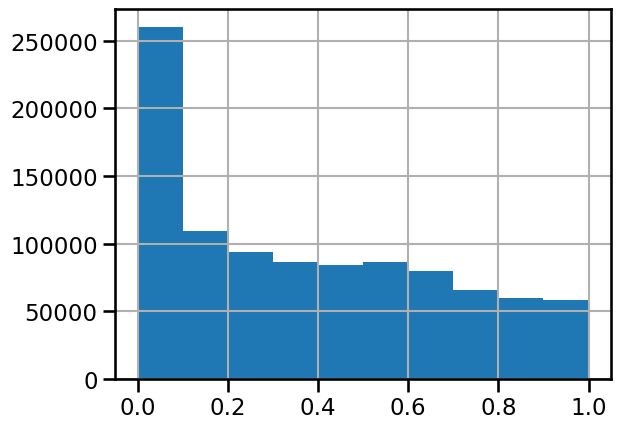

In [122]:
# has both accel and conserv positions
verteb["P"] = 10 ** (-1 * verteb["PhyloP_pos"])
verteb["P"].hist()

In [123]:
verteb["q"] = stats.false_discovery_control(verteb["P"])
verteb

chrom     start       end    PhyloP  PhyloP_pos         P         q
0          20  21513171  21513172 -1.348490    1.348490  0.044824  0.240017
1          20  21513172  21513173 -0.534118    0.534118  0.292336  0.629496
2          20  21513173  21513174  0.047575    0.047575  0.896242  0.954779
3          20  21513174  21513175 -0.068764    0.068764  0.853564  0.934848
4          20  21513175  21513176  0.280252    0.280252  0.524503  0.784351
...       ...       ...       ...       ...         ...       ...       ...
982939     11  31790647  31790648 -0.382843    0.382843  0.414149  0.726243
982940     11  31790648  31790649 -1.743030    1.743030  0.018070  0.137584
982941     11  31790649  31790650 -0.278213    0.278213  0.526971  0.785031
982942     11  31790650  31790651 -0.173583    0.173583  0.670528  0.847251
982943     11  31790651  31790652  0.349567    0.349567  0.447129  0.749064

[982944 rows x 7 columns]

In [124]:
bh_sig = verteb[verteb["q"] < 0.05]
bh_sig

chrom     start       end   PhyloP  PhyloP_pos         P         q
27         20  21513198  21513199 -4.02428     4.02428  0.000095  0.002715
31         20  21513202  21513203 -3.32624     3.32624  0.000472  0.009812
50         20  21513221  21513222 -3.09357     3.09357  0.000806  0.014873
55         20  21513226  21513227 -2.86089     2.86089  0.001378  0.022329
144        20  21513315  21513316 -2.97723     2.97723  0.001054  0.018264
...       ...       ...       ...      ...         ...       ...       ...
982650     11  31790358  31790359 -2.68470     2.68470  0.002067  0.030373
982682     11  31790390  31790391 -2.89396     2.89396  0.001277  0.021079
982713     11  31790421  31790422 -2.58007     2.58007  0.002630  0.036400
982813     11  31790521  31790522 -2.58007     2.58007  0.002630  0.036400
982857     11  31790565  31790566  3.06994     3.06994  0.000851  0.015525

[79867 rows x 7 columns]

In [125]:
bh_sig_conserv = verteb[verteb["PhyloP"] > 0]
bh_sig_conserv

chrom     start       end    PhyloP  PhyloP_pos         P         q
2          20  21513173  21513174  0.047575    0.047575  0.896242  0.954779
4          20  21513175  21513176  0.280252    0.280252  0.524503  0.784351
6          20  21513177  21513178  0.280252    0.280252  0.524503  0.784351
7          20  21513178  21513179  0.861945    0.861945  0.137422  0.443583
8          20  21513179  21513180  0.396591    0.396591  0.401244  0.715810
...       ...       ...       ...       ...         ...       ...       ...
982928     11  31790636  31790637  0.349567    0.349567  0.447129  0.749064
982929     11  31790637  31790638  1.081980    1.081980  0.082798  0.340914
982931     11  31790639  31790640  0.349567    0.349567  0.447129  0.749064
982934     11  31790642  31790643  0.663457    0.663457  0.217042  0.551021
982943     11  31790651  31790652  0.349567    0.349567  0.447129  0.749064

[560967 rows x 7 columns]

In [126]:
bh_sig_accel = verteb[verteb["PhyloP"] < 0]
bh_sig_accel

chrom     start       end    PhyloP  PhyloP_pos         P         q
0          20  21513171  21513172 -1.348490    1.348490  0.044824  0.240017
1          20  21513172  21513173 -0.534118    0.534118  0.292336  0.629496
3          20  21513174  21513175 -0.068764    0.068764  0.853564  0.934848
5          20  21513176  21513177 -0.650457    0.650457  0.223637  0.558693
13         20  21513184  21513185 -0.417780    0.417780  0.382138  0.702689
...       ...       ...       ...       ...         ...       ...       ...
982938     11  31790646  31790647 -0.278213    0.278213  0.526971  0.785031
982939     11  31790647  31790648 -0.382843    0.382843  0.414149  0.726243
982940     11  31790648  31790649 -1.743030    1.743030  0.018070  0.137584
982941     11  31790649  31790650 -0.278213    0.278213  0.526971  0.785031
982942     11  31790650  31790651 -0.173583    0.173583  0.670528  0.847251

[421977 rows x 7 columns]

Plan: Use variant analysis script to get variants in cds. Will save output as bed file.

In [127]:
#zoonomia_bed["ref"] 
verteb_bed = verteb[["chrom", "start", "end", "PhyloP"]]
verteb_bed

chrom     start       end    PhyloP
0          20  21513171  21513172 -1.348490
1          20  21513172  21513173 -0.534118
2          20  21513173  21513174  0.047575
3          20  21513174  21513175 -0.068764
4          20  21513175  21513176  0.280252
...       ...       ...       ...       ...
982939     11  31790647  31790648 -0.382843
982940     11  31790648  31790649 -1.743030
982941     11  31790649  31790650 -0.278213
982942     11  31790650  31790651 -0.173583
982943     11  31790651  31790652  0.349567

[982944 rows x 4 columns]

In [128]:
verteb_bed.to_csv("../soto_analysis/raw_files/100_verteb_15.bed", sep = "\t", header = None, index = None)

Ran scripts at http://localhost:8888/lab/workspaces/auto-E/tree/Desktop/Staller_Lab/SFARI/soto_analysis/notebooks/Zoonomia.ipynb? to get positions in CDS and domains

In [129]:
cds_phylo_P = []

for ENST in set(cc_names["ENST"]):
    df = pd.read_csv("../soto_analysis/outputs/mutations/cds_100_verteb_15/" + ENST + ".bed", sep = "\t", header = None)
    cds_phylo_P.append(df)

cds_phylo_P = pd.concat(cds_phylo_P)
cds_phylo_P = cds_phylo_P.rename(columns = {4: "ENST", 9: "PhyloP"})
cds_phylo_P

0         1         2       3             ENST  5   6         7  \
0      7  50319061  50319062  Q13422  ENST00000331340  +   7  50319061   
1      7  50319062  50319063  Q13422  ENST00000331340  +   7  50319062   
2      7  50319063  50319064  Q13422  ENST00000331340  +   7  50319063   
3      7  50319064  50319065  Q13422  ENST00000331340  +   7  50319064   
4      7  50319065  50319066  Q13422  ENST00000331340  +   7  50319065   
...   ..       ...       ...     ...              ... ..  ..       ...   
1429  15  37099461  37099462  O14770  ENST00000561208  -  15  37099461   
1430  15  37099462  37099463  O14770  ENST00000561208  -  15  37099462   
1431  15  37099463  37099464  O14770  ENST00000561208  -  15  37099463   
1432  15  37099464  37099465  O14770  ENST00000561208  -  15  37099464   
1433  15  37099465  37099466  O14770  ENST00000561208  -  15  37099465   

             8   PhyloP  
0     50319062  8.06732  
1     50319063  6.83065  
2     50319064  8.62945  
3     50319065  6.83065  
4     50319066  8.06732  
...        ...      ...  
1429  37099462  8.95900  
1430  37099463  7.00776  
1431  37099464  7.00776  
1432  37099465  8.33815  
1433  37099466  7.09645  

[19443 rows x 10 columns]

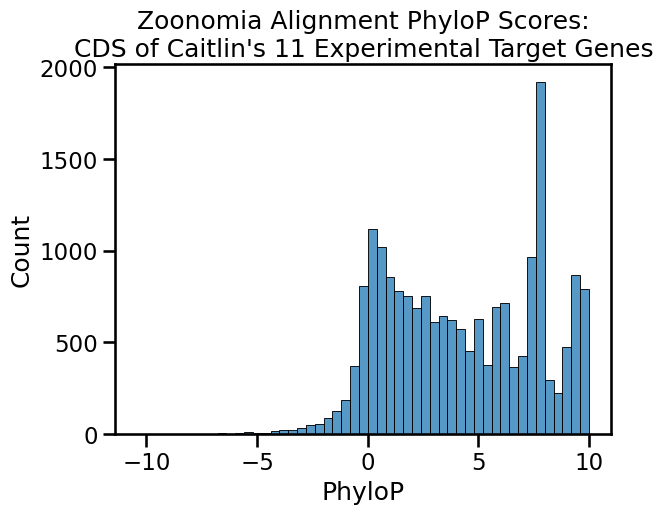

In [130]:
plt.title("Zoonomia Alignment PhyloP Scores:\nCDS of Caitlin's 11 Experimental Target Genes");
sns.histplot(cds_phylo_P["PhyloP"], bins = 51);

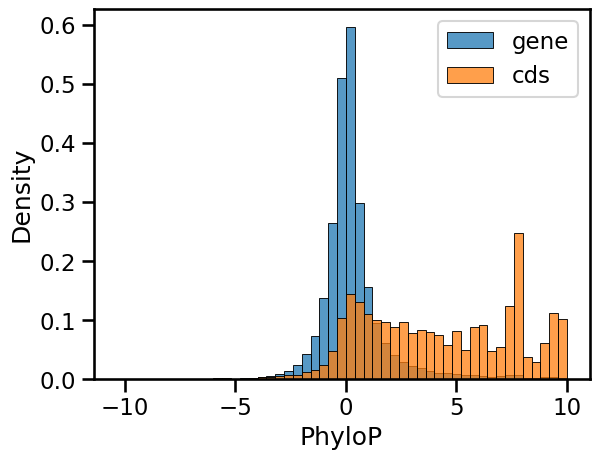

In [131]:
sns.histplot(verteb["PhyloP"], bins = 51, label = "gene", stat = "density")
sns.histplot(cds_phylo_P["PhyloP"], bins = 51, label = "cds", stat = "density")
plt.legend();

In [132]:
ad_phylo_P = []

for ENST in set(cc_names["ENST"]):
    df = pd.read_csv("../soto_analysis/outputs/mutations/domains_100_verteb_15/" + ENST + ".bed", sep = "\t", header = None)
    ad_phylo_P.append(df)

ad_phylo_P = pd.concat(ad_phylo_P)
ad_phylo_P = ad_phylo_P.rename(columns = {4: "ENST", 17: "PhyloP"})
dbd_phylo_P = ad_phylo_P[ad_phylo_P[3] == "DBD"]
ad_phylo_P = ad_phylo_P[ad_phylo_P[3] == "AD"]
ad_phylo_P

0         1         2   3             ENST  5  6                7   8  \
0     7  50376792  50376793  AD  ENSG00000185811  .  +  ENST00000331340   7   
1     7  50399917  50399918  AD  ENSG00000185811  .  +  ENST00000331340   7   
2     7  50399918  50399919  AD  ENSG00000185811  .  +  ENST00000331340   7   
3     7  50399919  50399920  AD  ENSG00000185811  .  +  ENST00000331340   7   
4     7  50399920  50399921  AD  ENSG00000185811  .  +  ENST00000331340   7   
..   ..       ...       ...  ..              ... .. ..              ...  ..   
598  15  36896641  36896642  AD  ENSG00000134138  .  -  ENST00000561208  15   
599  15  36896642  36896643  AD  ENSG00000134138  .  -  ENST00000561208  15   
600  15  36896643  36896644  AD  ENSG00000134138  .  -  ENST00000561208  15   
601  15  36896644  36896645  AD  ENSG00000134138  .  -  ENST00000561208  15   
602  15  36896645  36896646  AD  ENSG00000134138  .  -  ENST00000561208  15   

            9        10      11               12 13  14        15        16  \
0    50376792  50376793  Q13422  ENST00000331340  +   7  50376792  50376793   
1    50399917  50399918  Q13422  ENST00000331340  +   7  50399917  50399918   
2    50399918  50399919  Q13422  ENST00000331340  +   7  50399918  50399919   
3    50399919  50399920  Q13422  ENST00000331340  +   7  50399919  50399920   
4    50399920  50399921  Q13422  ENST00000331340  +   7  50399920  50399921   
..        ...       ...     ...              ... ..  ..       ...       ...   
598  36896641  36896642  O14770  ENST00000561208  -  15  36896641  36896642   
599  36896642  36896643  O14770  ENST00000561208  -  15  36896642  36896643   
600  36896643  36896644  O14770  ENST00000561208  -  15  36896643  36896644   
601  36896644  36896645  O14770  ENST00000561208  -  15  36896644  36896645   
602  36896645  36896646  O14770  ENST00000561208  -  15  36896645  36896646   

      PhyloP  
0    9.99200  
1    9.67770  
2    1.41213  
3    9.67770  
4    9.03195  
..       ...  
598  7.87603  
599  9.94000  
600  5.81206  
601  7.87603  
602  7.76740  

[5145 rows x 18 columns]

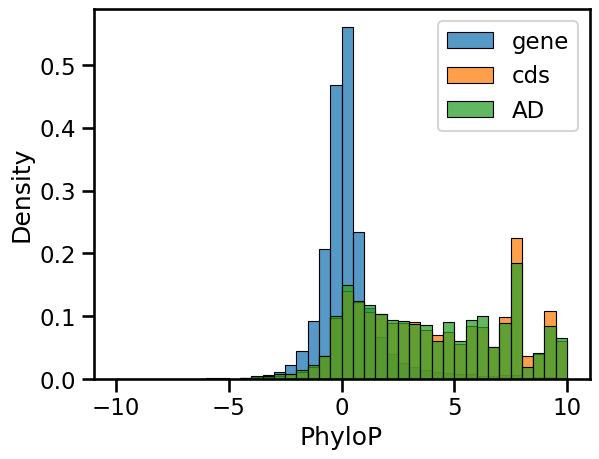

In [133]:
bins = np.arange(-10, 10.1, 0.5)
sns.histplot(verteb["PhyloP"], label = "gene", stat = "density", bins = bins)
sns.histplot(cds_phylo_P["PhyloP"], label = "cds", stat = "density", bins = bins)
sns.histplot(ad_phylo_P["PhyloP"], label = "AD", stat = "density", bins = bins)
plt.legend();

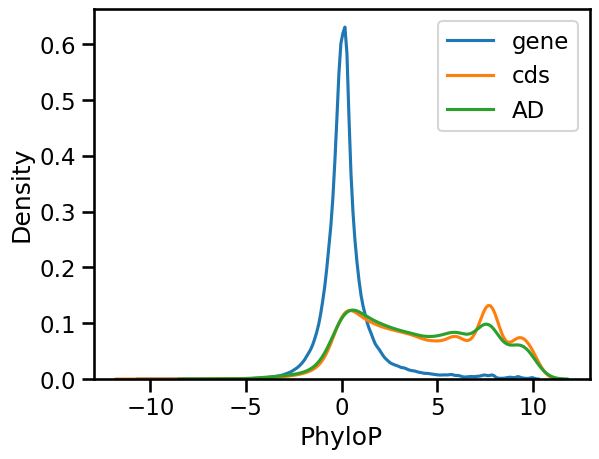

In [134]:
bins = np.arange(-10, 10.1, 0.5)
sns.kdeplot(verteb["PhyloP"], label = "gene")
sns.kdeplot(cds_phylo_P["PhyloP"], label = "cds")
sns.kdeplot(ad_phylo_P["PhyloP"], label = "AD")
plt.legend();

In [135]:
# For each AD, plot conservation, then add annotated AD and DBDs

In [136]:
ENST = "ENST00000241001"
ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
ENST_phylo_P

0         1         2       3             ENST  5   6         7  \
0     11  31789933  31789934  P26367  ENST00000241001  -  11  31789933   
1     11  31789934  31789935  P26367  ENST00000241001  -  11  31789934   
2     11  31789935  31789936  P26367  ENST00000241001  -  11  31789935   
3     11  31789936  31789937  P26367  ENST00000241001  -  11  31789936   
4     11  31789937  31789938  P26367  ENST00000241001  -  11  31789937   
...   ..       ...       ...     ...              ... ..  ..       ...   
1264  11  31806406  31806407  P26367  ENST00000241001  -  11  31806406   
1265  11  31806407  31806408  P26367  ENST00000241001  -  11  31806407   
1266  11  31806408  31806409  P26367  ENST00000241001  -  11  31806408   
1267  11  31806409  31806410  P26367  ENST00000241001  -  11  31806409   
1268  11  31806410  31806411  P26367  ENST00000241001  -  11  31806410   

             8   PhyloP  
0     31789934  3.80235  
1     31789935  3.80235  
2     31789936  4.84865  
3     31789937  5.58106  
4     31789938  5.68569  
...        ...      ...  
1264  31806407  4.70253  
1265  31806408  5.92197  
1266  31806409  4.70253  
1267  31806410  5.54676  
1268  31806411  4.70253  

[1269 rows x 10 columns]

In [137]:
# If negative strand, sort ascending = False
# Else, sort ascending = True
if ENST_phylo_P[5].iloc[0] == "-":
    ascending = False
else: 
    ascending = True
ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
ENST_phylo_P

0         1         2       3             ENST  5   6         7  \
1268  11  31806410  31806411  P26367  ENST00000241001  -  11  31806410   
1267  11  31806409  31806410  P26367  ENST00000241001  -  11  31806409   
1266  11  31806408  31806409  P26367  ENST00000241001  -  11  31806408   
1265  11  31806407  31806408  P26367  ENST00000241001  -  11  31806407   
1264  11  31806406  31806407  P26367  ENST00000241001  -  11  31806406   
...   ..       ...       ...     ...              ... ..  ..       ...   
4     11  31789937  31789938  P26367  ENST00000241001  -  11  31789937   
3     11  31789936  31789937  P26367  ENST00000241001  -  11  31789936   
2     11  31789935  31789936  P26367  ENST00000241001  -  11  31789935   
1     11  31789934  31789935  P26367  ENST00000241001  -  11  31789934   
0     11  31789933  31789934  P26367  ENST00000241001  -  11  31789933   

             8   PhyloP  
1268  31806411  4.70253  
1267  31806410  5.54676  
1266  31806409  4.70253  
1265  31806408  5.92197  
1264  31806407  4.70253  
...        ...      ...  
4     31789938  5.68569  
3     31789937  5.58106  
2     31789936  4.84865  
1     31789935  3.80235  
0     31789934  3.80235  

[1269 rows x 10 columns]

In [138]:
uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
uniprotID

'P26367'

In [139]:
domains = pd.read_csv("../soto_analysis/outputs/mutations/domains_zoonomia_15/" + ENST + ".bed", sep = "\t", header = None)
domains = domains[[0, 1, 2, 3]]
domains

0         1         2    3
0    11  31800823  31800824  DBD
1    11  31800824  31800825  DBD
2    11  31800825  31800826  DBD
3    11  31800826  31800827  DBD
4    11  31800827  31800828  DBD
..   ..       ...       ...  ...
832  11  31793752  31793753   AD
833  11  31793753  31793754   AD
834  11  31793754  31793755   AD
835  11  31793755  31793756   AD
836  11  31793756  31793757   AD

[837 rows x 4 columns]

In [140]:
ENST_phylo_P_with_domains = pd.merge(ENST_phylo_P, domains, how = "left", on = [0, 1, 2])
ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.fillna(0)
ENST_phylo_P_with_domains["cds_nt"] = np.arange(len(ENST_phylo_P_with_domains))
ENST_phylo_P_with_domains

0         1         2     3_x             ENST  5   6         7  \
0     11  31806410  31806411  P26367  ENST00000241001  -  11  31806410   
1     11  31806409  31806410  P26367  ENST00000241001  -  11  31806409   
2     11  31806408  31806409  P26367  ENST00000241001  -  11  31806408   
3     11  31806407  31806408  P26367  ENST00000241001  -  11  31806407   
4     11  31806406  31806407  P26367  ENST00000241001  -  11  31806406   
...   ..       ...       ...     ...              ... ..  ..       ...   
1264  11  31789937  31789938  P26367  ENST00000241001  -  11  31789937   
1265  11  31789936  31789937  P26367  ENST00000241001  -  11  31789936   
1266  11  31789935  31789936  P26367  ENST00000241001  -  11  31789935   
1267  11  31789934  31789935  P26367  ENST00000241001  -  11  31789934   
1268  11  31789933  31789934  P26367  ENST00000241001  -  11  31789933   

             8   PhyloP 3_y  cds_nt  
0     31806411  4.70253   0       0  
1     31806410  5.54676   0       1  
2     31806409  4.70253   0       2  
3     31806408  5.92197   0       3  
4     31806407  4.70253   0       4  
...        ...      ...  ..     ...  
1264  31789938  5.68569  AD    1264  
1265  31789937  5.58106  AD    1265  
1266  31789936  4.84865   0    1266  
1267  31789935  3.80235   0    1267  
1268  31789934  3.80235   0    1268  

[1269 rows x 12 columns]

In [141]:
#https://www.geeksforgeeks.org/python-make-a-list-of-intervals-with-sequential-numbers/
def intervals_extract(iterable):
     
    iterable = sorted(set(iterable))
    for key, group in itertools.groupby(enumerate(iterable),
    lambda t: t[1] - t[0]):
        group = list(group)
        yield [group[0][1], group[-1][1]]

In [142]:
list(intervals_extract(ENST_phylo_P_with_domains["cds_nt"]))

[[0, 1268]]

In [143]:
tfs_tbl = pd.read_csv("../soto_analysis/outputs/TFs_table_proteins.txt", sep = "\t")
tfs_tbl

Unnamed: 0   1   2 uniprotID             ENSG             ENST DBD_coords  \
0            0 NaN NaN    O14770  ENSG00000134138  ENST00000561208    276-338   
1            1 NaN NaN    O60479  ENSG00000064195  ENST00000434704    129-188   
2            2 NaN NaN    O75840  ENSG00000118263  ENST00000309446      NA-NA   
3            3 NaN NaN    O94983  ENSG00000108509  ENST00000348066     30-155   
4            4 NaN NaN    O95096  ENSG00000125820  ENST00000377142    128-187   
5            5 NaN NaN    P10827  ENSG00000126351  ENST00000264637     53-127   
6            6 NaN NaN    P11308  ENSG00000157554  ENST00000288319    311-391   
7            7 NaN NaN    P11473  ENSG00000111424  ENST00000395324      21-96   
8            8 NaN NaN    P15884  ENSG00000196628  ENST00000356073      NA-NA   
9            9 NaN NaN    P19532  ENSG00000068323  ENST00000315869      NA-NA   
10          10 NaN NaN    P20393  ENSG00000126368  ENST00000246672    129-205   
11          11 NaN NaN    P25490  ENSG00000100811  ENST00000262238      NA-NA   
12          12 NaN NaN    P26367  ENSG00000007372  ENST00000241001      4-130   
13          13 NaN NaN    P32242  ENSG00000115507  ENST00000282549      38-97   
14          14 NaN NaN    P35398  ENSG00000069667  ENST00000335670     73-138   
15          15 NaN NaN    P35548  ENSG00000120149  ENST00000239243    142-201   
16          16 NaN NaN    P43354  ENSG00000153234  ENST00000339562    260-335   
17          17 NaN NaN    P78337  ENSG00000069011  ENST00000265340     89-148   
18          18 NaN NaN    Q02548  ENSG00000196092  ENST00000358127     16-142   
19          19 NaN NaN    Q03164  ENSG00000118058  ENST00000389506    169-180   
20          20 NaN NaN    Q06413  ENSG00000081189  ENST00000437473      58-86   
21          21 NaN NaN    Q06889  ENSG00000179388  ENST00000317216      NA-NA   
22          22 NaN NaN    Q12857  ENSG00000162599  ENST00000403491      1-194   
23          23 NaN NaN    Q13422  ENSG00000185811  ENST00000331340      NA-NA   
24          24 NaN NaN    Q13485  ENSG00000141646  ENST00000342988      NA-NA   
25          25 NaN NaN    Q14872  ENSG00000188786  ENST00000373036      NA-NA   
26          26 NaN NaN    Q14938  ENSG00000008441  ENST00000592199      1-194   
27          27 NaN NaN    Q15788  ENSG00000084676  ENST00000348332      NA-NA   
28          28 NaN NaN    Q5T1R4  ENSG00000127124  ENST00000372583      NA-NA   
29          29 NaN NaN    Q6N021  ENSG00000168769  ENST00000380013      NA-NA   
30          30 NaN NaN    Q6P1N0  ENSG00000132024  ENST00000318003      NA-NA   
31          31 NaN NaN    Q6ZRS2  ENSG00000080603  ENST00000262518  2857-2869   
32          32 NaN NaN    Q86V15  ENSG00000130940  ENST00000377022      NA-NA   
33          33 NaN NaN    Q8NBF1  ENSG00000174332  ENST00000312233      NA-NA   
34          34 NaN NaN    Q92731  ENSG00000140009  ENST00000341099    149-214   
35          35 NaN NaN    Q96QS3  ENSG00000004848  ENST00000379044    328-387   
36          36 NaN NaN    Q9BXK1  ENSG00000129911  ENST00000250916      NA-NA   
37          37 NaN NaN    Q9H4W6  ENSG00000108001  ENST00000355311      NA-NA   
38          38 NaN NaN    Q9HBZ2  ENSG00000172379  ENST00000303329      NA-NA   
39          39 NaN NaN    Q9NQB0  ENSG00000148737  ENST00000355995    350-418   
40          40 NaN NaN    Q9UGL1  ENSG00000117139  ENST00000367265      NA-NA   
41          41 NaN NaN    Q9UGU0  ENSG00000100207  ENST00000359486  1537-1551   
42          42 NaN NaN    Q9UL68  ENSG00000186487  ENST00000428368      NA-NA   
43          43 NaN NaN    Q9Y458  ENSG00000122145  ENST00000373294     96-283   
44          44 NaN NaN    Q9Y4A8  ENSG00000050344  ENST00000056233      NA-NA   

                  AD_coords  RD_coords  Bif_coords  length  
0                   340-477        NaN         NaN       1  
1              199-263,2-91        NaN         NaN       1  
2                     2-101        NaN         NaN       1  
3           285-468,472-581      

In [144]:
cds_phylo_P[cds_phylo_P["ENST"] == "ENST00000331340"]

0         1         2       3             ENST  5  6         7  \
0     7  50319061  50319062  Q13422  ENST00000331340  +  7  50319061   
1     7  50319062  50319063  Q13422  ENST00000331340  +  7  50319062   
2     7  50319063  50319064  Q13422  ENST00000331340  +  7  50319063   
3     7  50319064  50319065  Q13422  ENST00000331340  +  7  50319064   
4     7  50319065  50319066  Q13422  ENST00000331340  +  7  50319065   
...  ..       ...       ...     ...              ... .. ..       ...   
1555  7  50400622  50400623  Q13422  ENST00000331340  +  7  50400622   
1556  7  50400623  50400624  Q13422  ENST00000331340  +  7  50400623   
1557  7  50400624  50400625  Q13422  ENST00000331340  +  7  50400624   
1558  7  50400625  50400626  Q13422  ENST00000331340  +  7  50400625   
1559  7  50400626  50400627  Q13422  ENST00000331340  +  7  50400626   

             8    PhyloP  
0     50319062  8.067320  
1     50319063  6.830650  
2     50319064  8.629450  
3     50319065  6.830650  
4     50319066  8.067320  
...        ...       ...  
1555  50400623  4.028420  
1556  50400624  0.942787  
1557  50400625  3.904990  
1558  50400626  3.781570  
1559  50400627  3.164440  

[1560 rows x 10 columns]

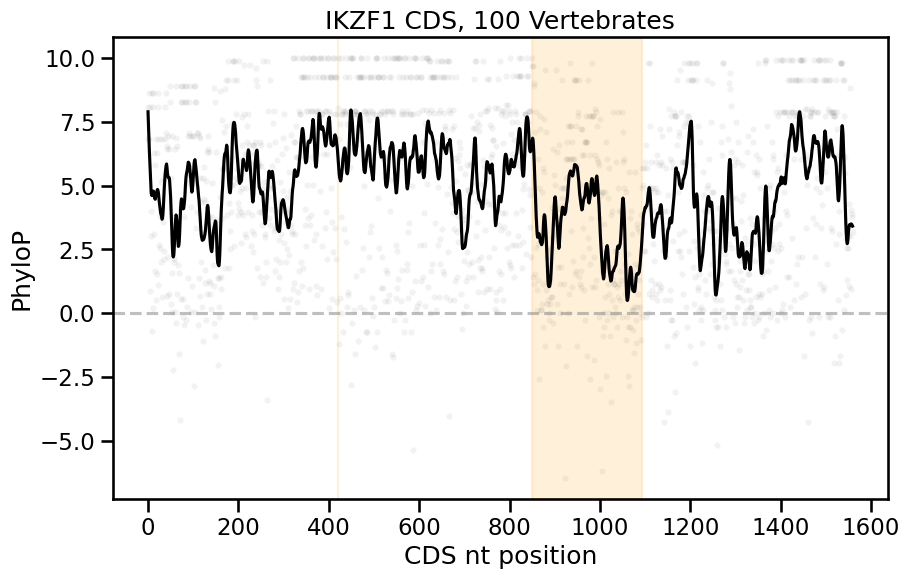

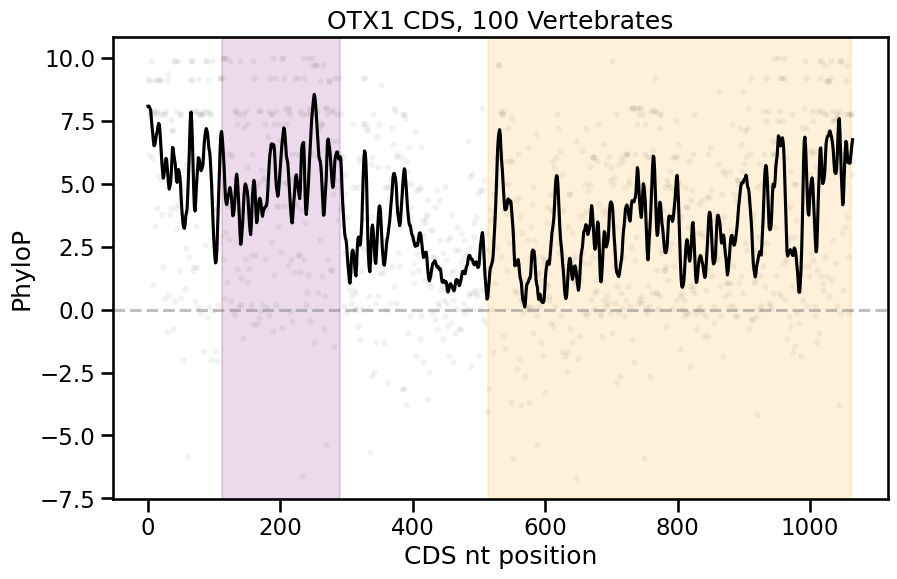

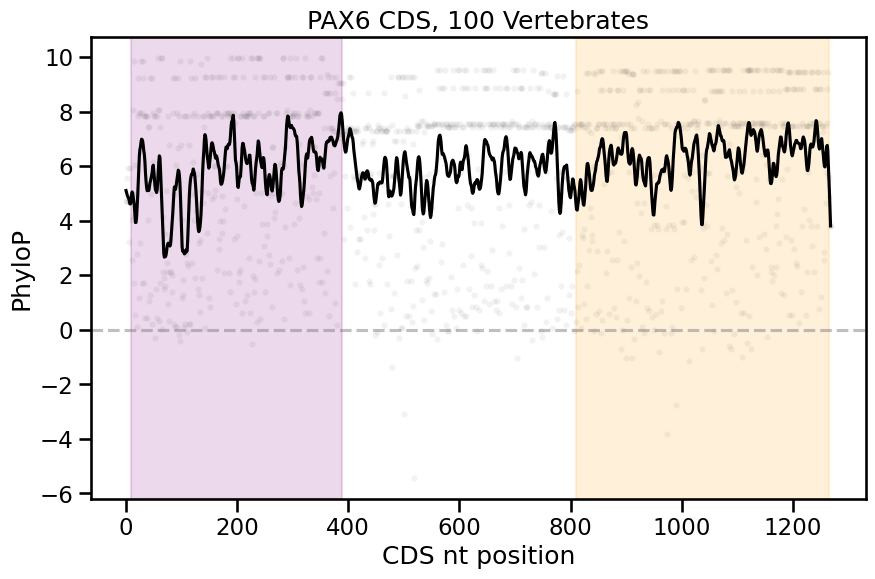

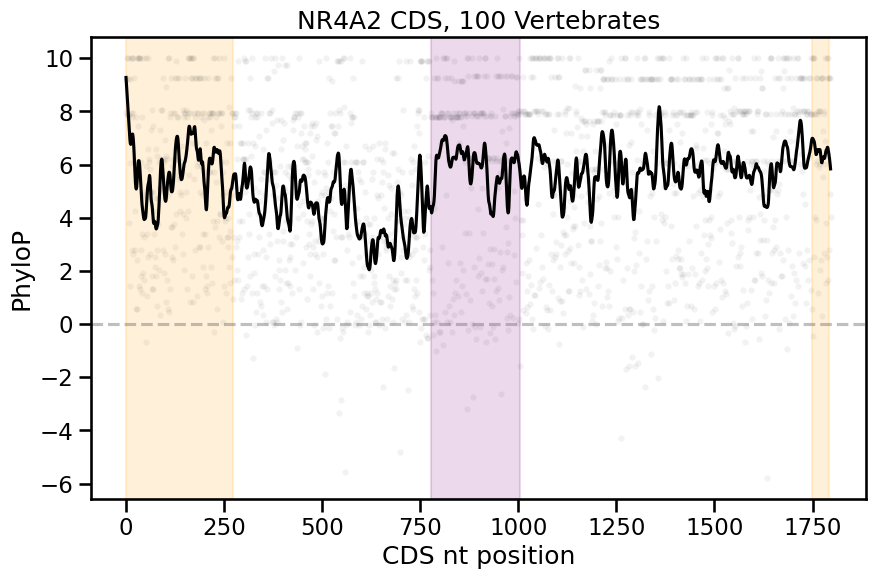

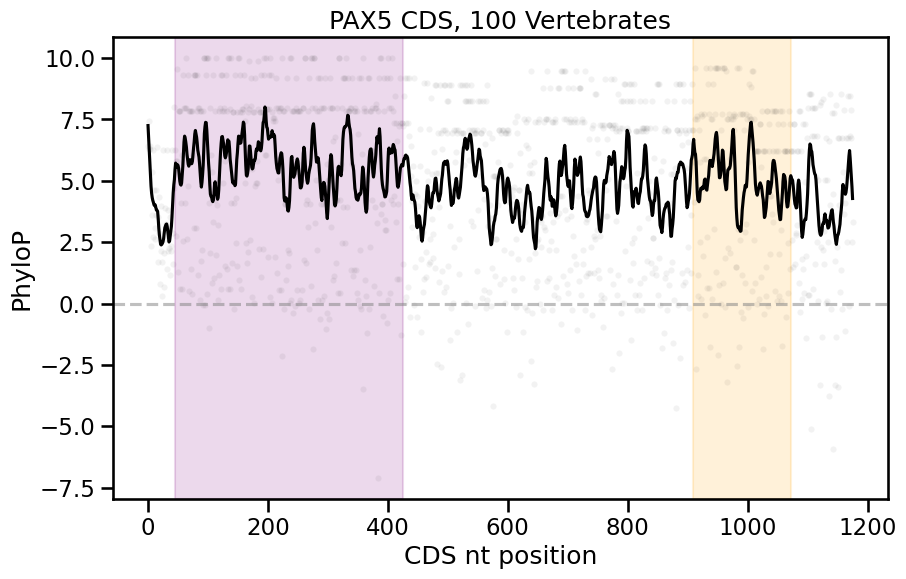

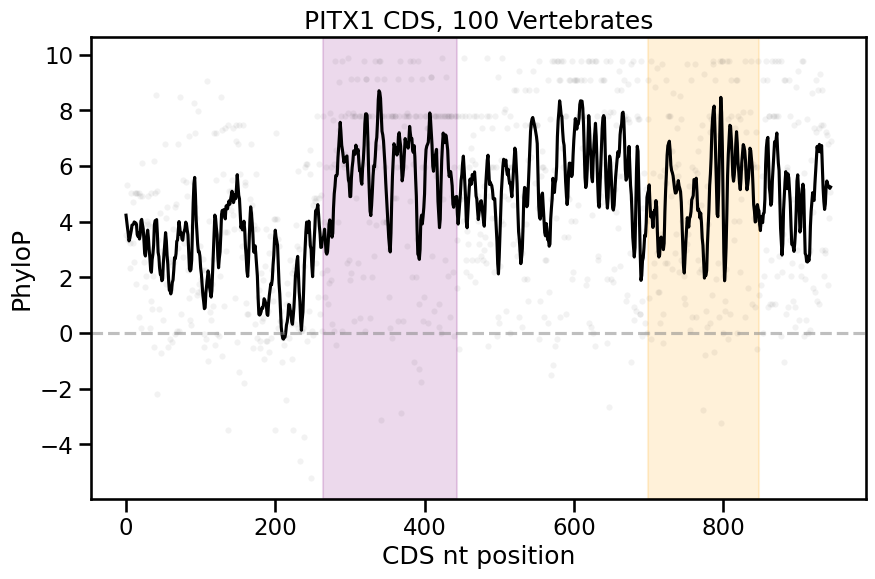

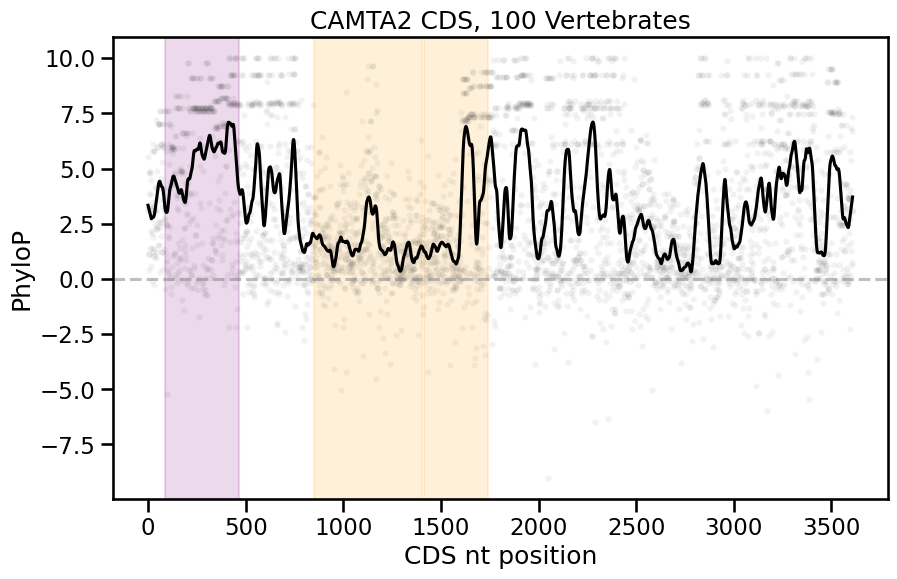

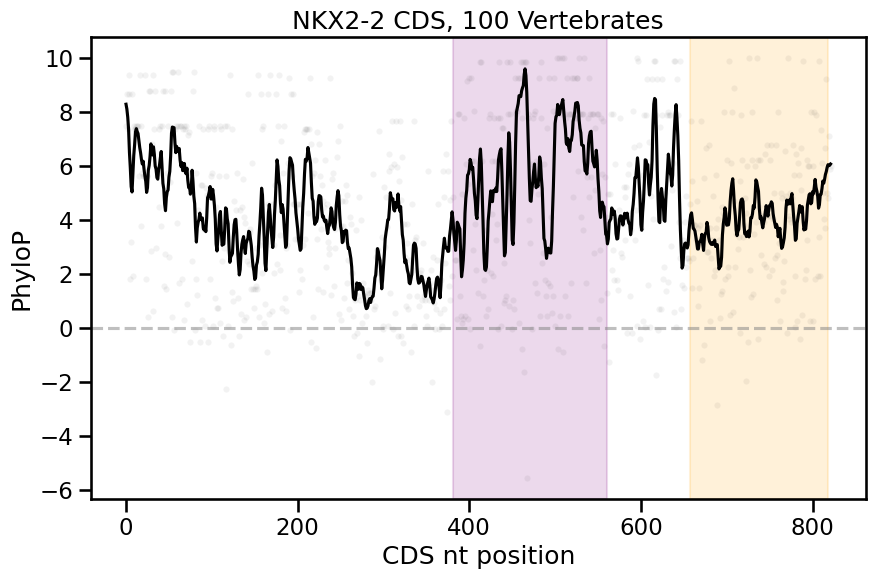

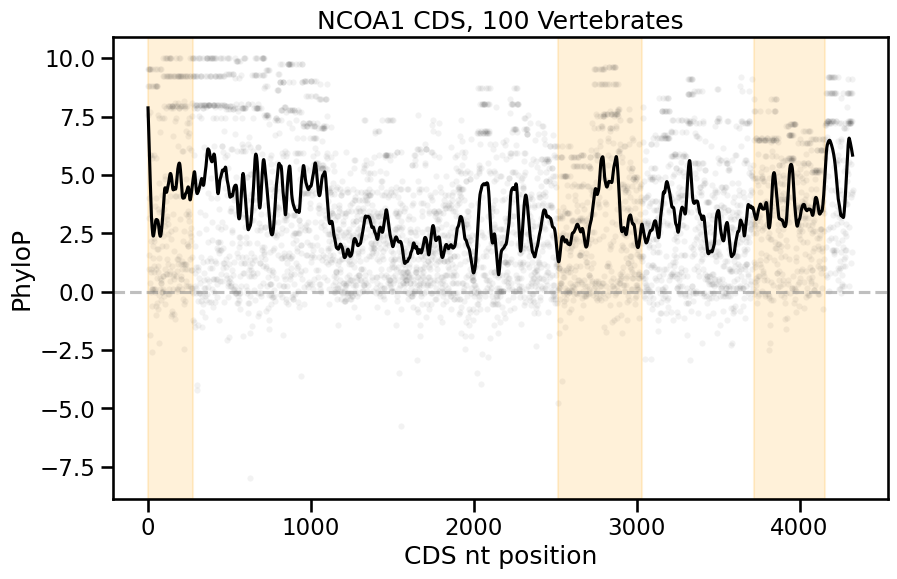

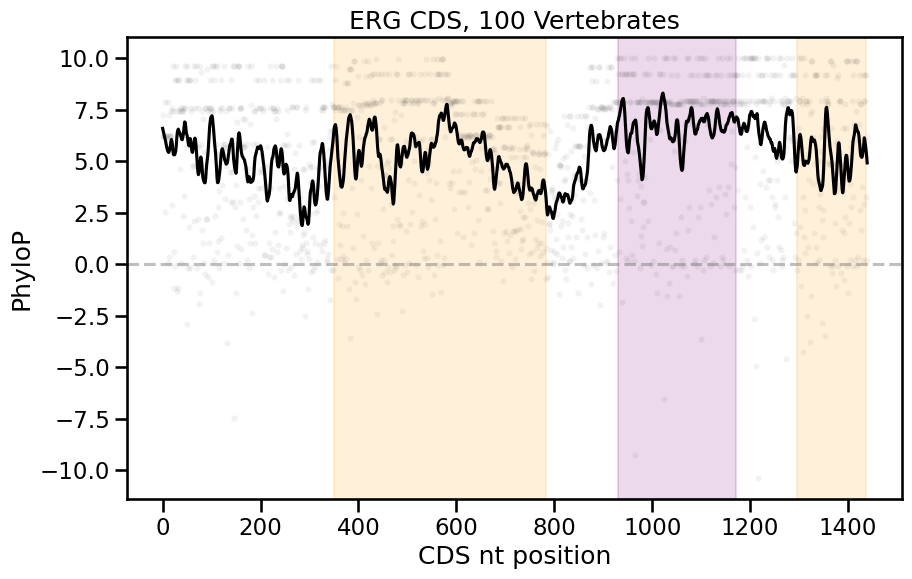

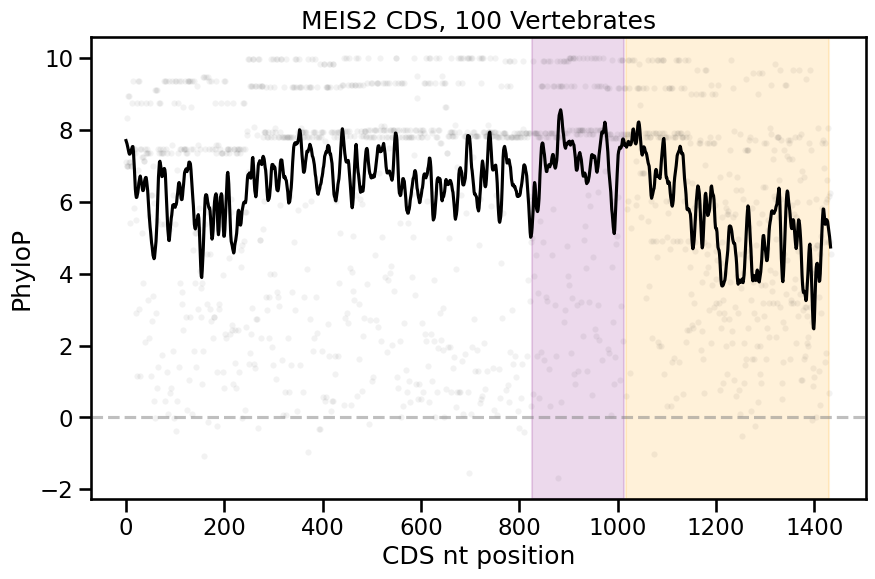

In [145]:
for ENST in set(cc_names["ENST"]):
    #display(tfs_tbl[tfs_tbl["ENST"] == ENST])
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    # If negative strand, sort ascending = False
    # Else, sort ascending = True
    if ENST_phylo_P[5].iloc[0] == "-":
        ascending = False
    else: 
        ascending = True
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    domains = pd.read_csv("../soto_analysis/outputs/mutations/domains_100_verteb_15/" + ENST + ".bed", sep = "\t", header = None)
    domains = domains[[0, 1, 2, 3]]
    ENST_phylo_P_with_domains = pd.merge(ENST_phylo_P, domains, how = "left", on = [0, 1, 2])
    ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.fillna(0)
    ENST_phylo_P_with_domains["cds_nt"] = np.arange(len(ENST_phylo_P_with_domains))
    #display(ENST_phylo_P_with_domains)


    # Apply lowess smoothing
    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    
    smoothed = lowess(ENST_phylo_P_with_domains['PhyloP'], ENST_phylo_P_with_domains["cds_nt"], frac=0.01)  # Adjust frac for smoothness
    color_map = {
        'AD': 'orange',
        'DBD': 'purple'
    }
    
    # Create a new DataFrame for smoothed data
    smoothed_df = pd.DataFrame(smoothed, columns=["cds_nt", 'smoothed'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    
    # Create background color blocks based on '3_y'
    for value, color in color_map.items():
        subset = ENST_phylo_P_with_domains[ENST_phylo_P_with_domains['3_y'] == value]
        intervals = list(intervals_extract(subset["cds_nt"]))
        
        for interval in intervals:
            plt.axvspan(interval[0], interval[1], color=color, alpha=0.15)

    sns.scatterplot(data=ENST_phylo_P_with_domains, x="cds_nt", y='PhyloP', color='black', alpha = 0.05, s = 20)
    sns.lineplot(data=smoothed_df, x="cds_nt", y='smoothed', color='black')
    plt.axhline(0, color = "gray", linestyle = "--", alpha = 0.5)
    #plt.ylim(0, 10)
    # Add labels and legend
    #print(ENST)
    plt.title(gene + ' CDS, 100 Vertebrates')
    plt.xlabel('CDS nt position')  
    # plt.ylabel('PhyloP Score')
    #plt.legend(title='Domain Type')
    plt.show()


In [146]:
lambert_TFs = pd.read_csv("../data/LambertTFs.csv", index_col = 0)
lambert_TFs["uniprotID"] = lambert_TFs["GeneName"].str.split("|").str[1]
lambert_TFs

GeneName  \
0      sp|P23511|NFYA_HUMAN   
1       sp|Q96QS3|ARX_HUMAN   
2     sp|P31270|HXA11_HUMAN   
3     sp|P50221|MEOX1_HUMAN   
4      sp|P57073|SOX8_HUMAN   
...                     ...   
1603  sp|P35227|PCGF2_HUMAN   
1604  sp|Q9BS34|ZN670_HUMAN   
1605   sp|P17098|ZNF8_HUMAN   
1606  sp|Q9UJW7|ZN229_HUMAN   
1607  sp|Q9Y5X4|NR2E3_HUMAN   

                                             ProteinSeq uniprotID  
0     MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...    P23511  
1     MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...    Q96QS3  
2     MDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTPSSRPMTYS...    P31270  
3     MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSFH...    P50221  
4     MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAGSEGLGRAG...    P57073  
...                                                 ...       ...  
1603  MHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSFCKTCIVRY...    P35227  
1604  MDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFRNLASVGNK...    Q9BS34  
1605  MDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEEWGQLDPTQ...    P17098  
1606  METLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKDVAVVFTEE...    Q9UJW7  
1607  METRPTALMSSTVAAAAPAAGAASRKESPGRWGLGEDPTGVSPSLQ...    Q9Y5X4  

[1608 rows x 3 columns]

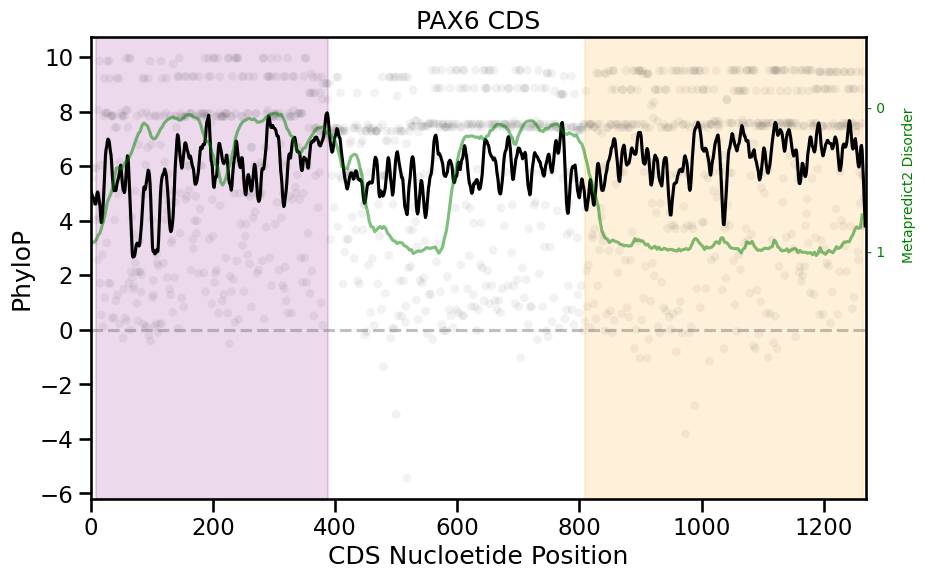

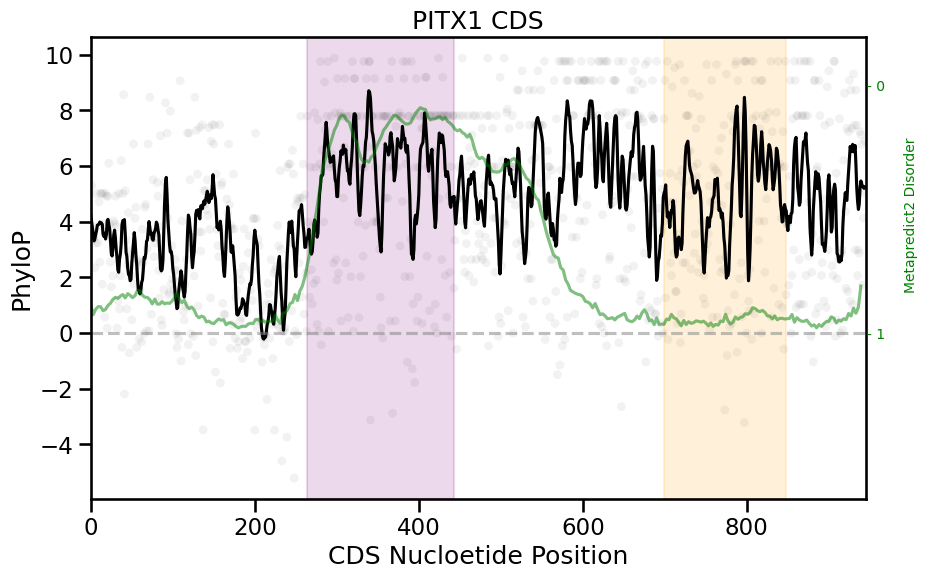

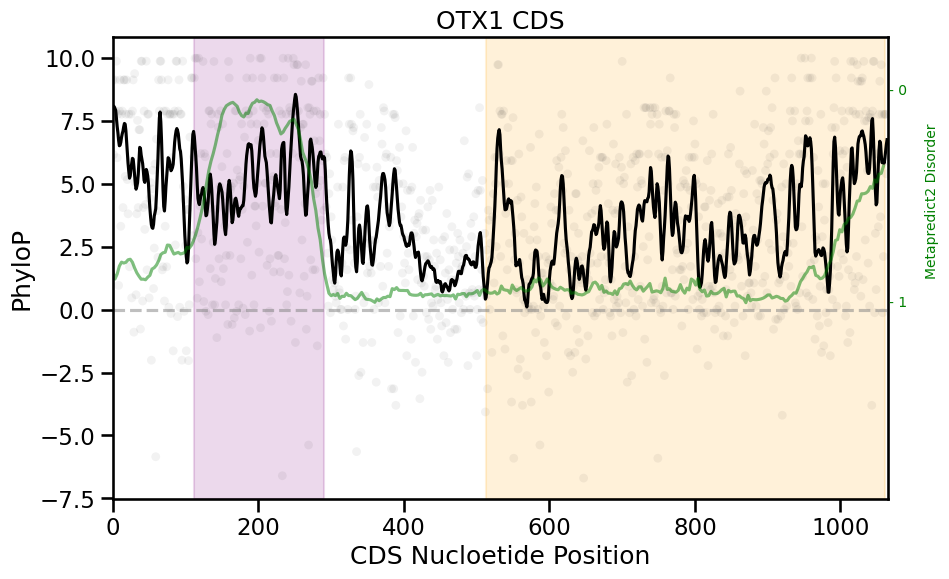

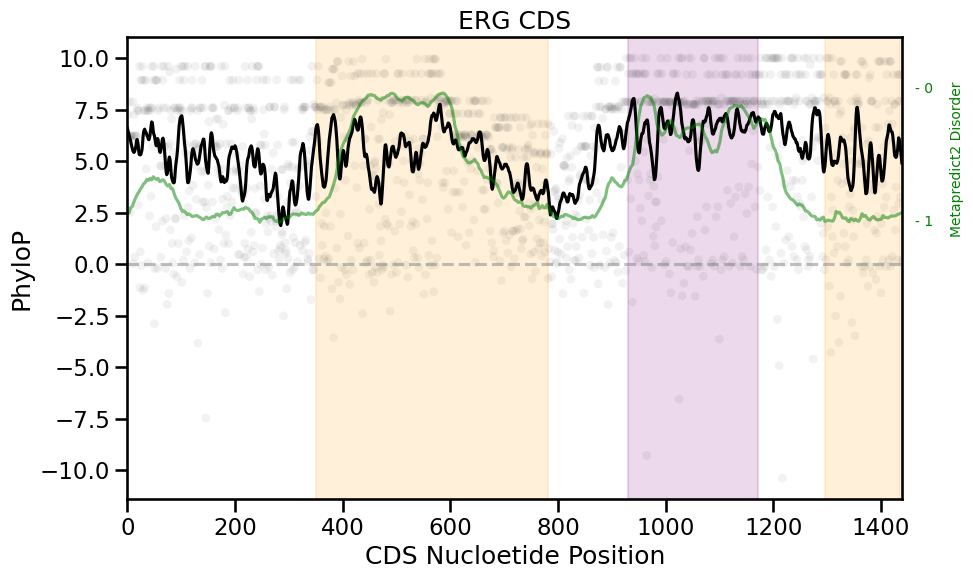

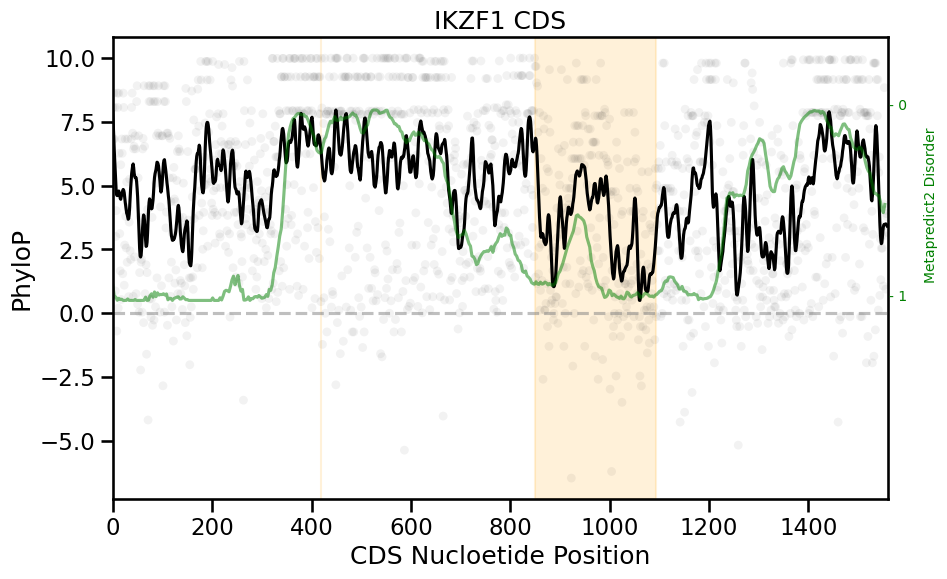

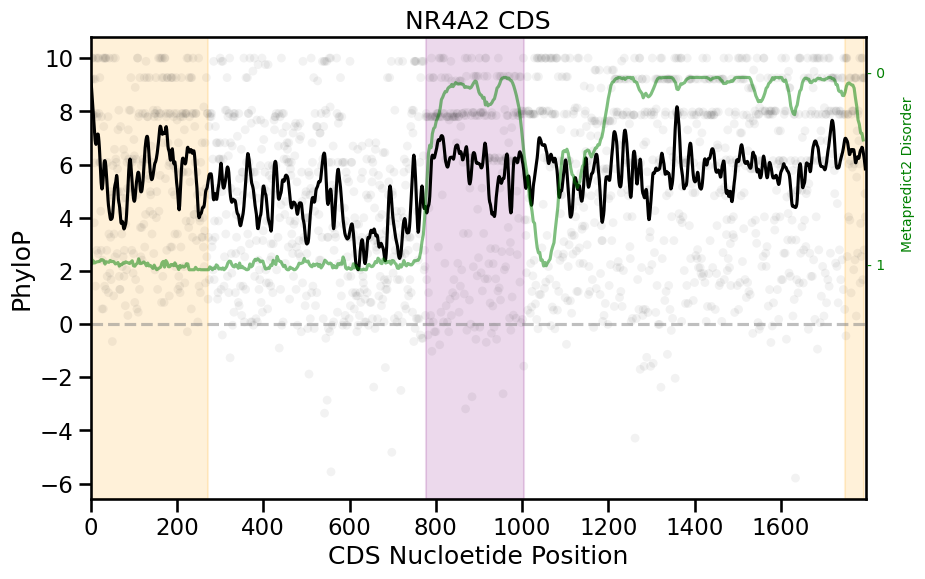

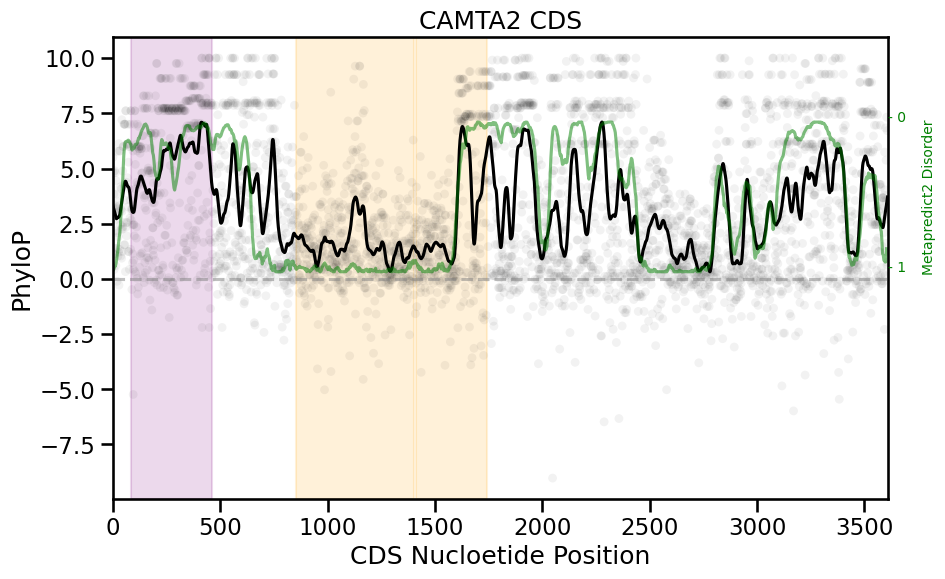

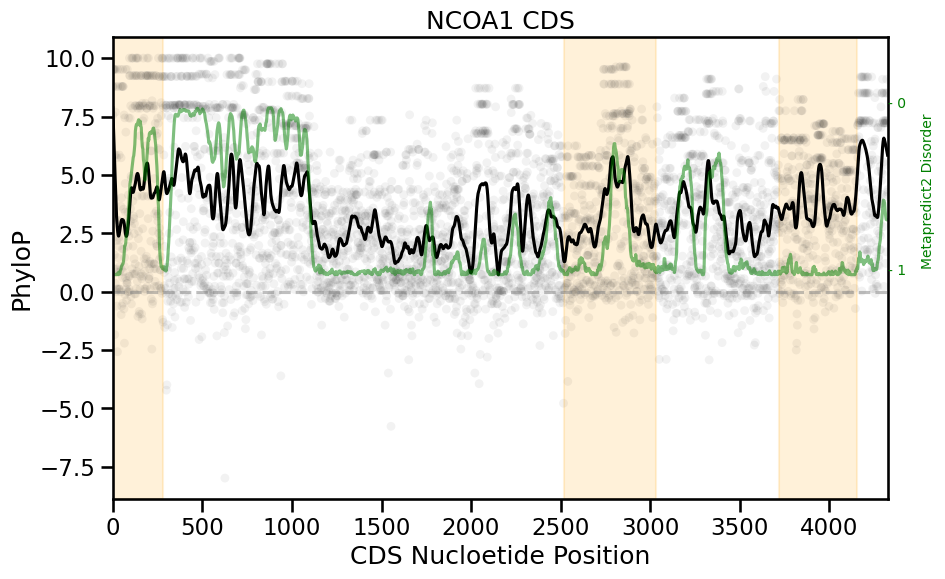

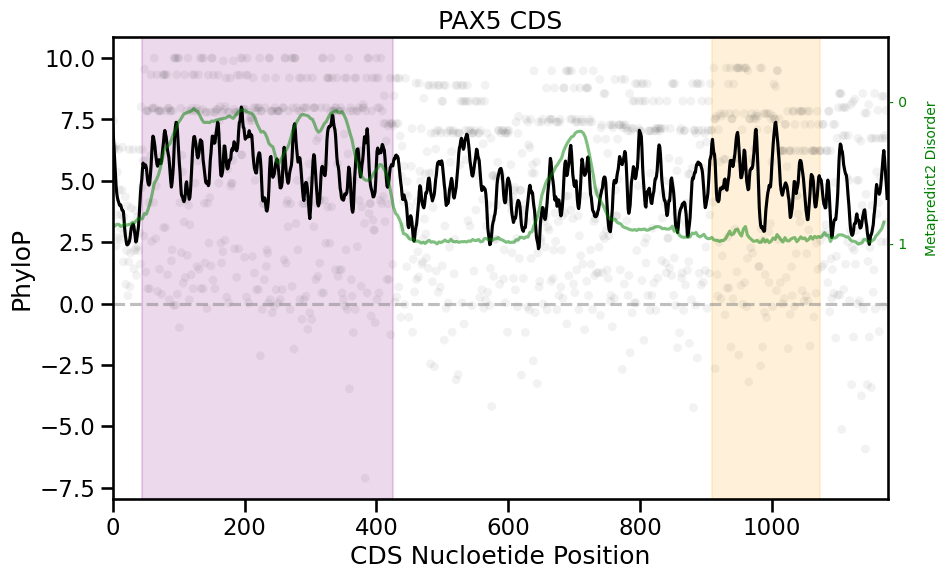

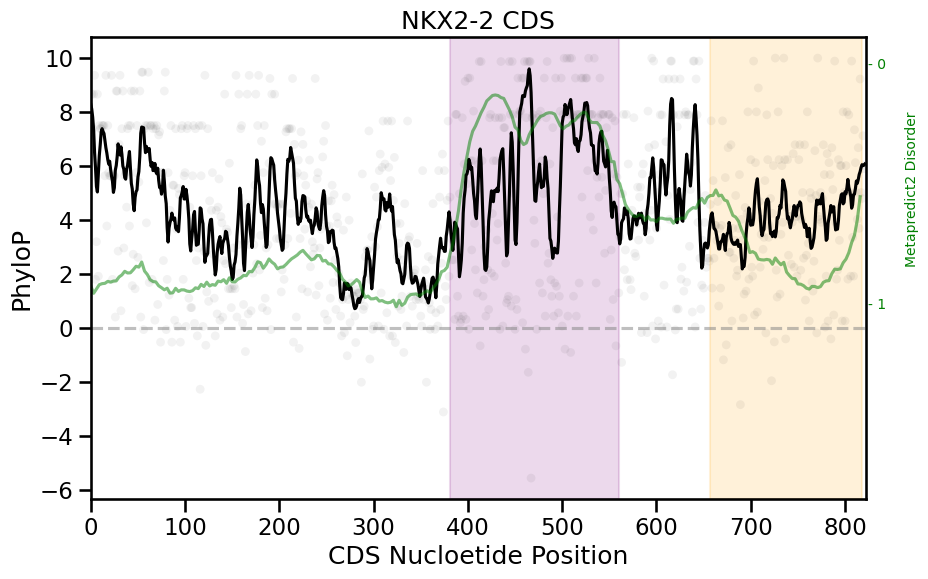

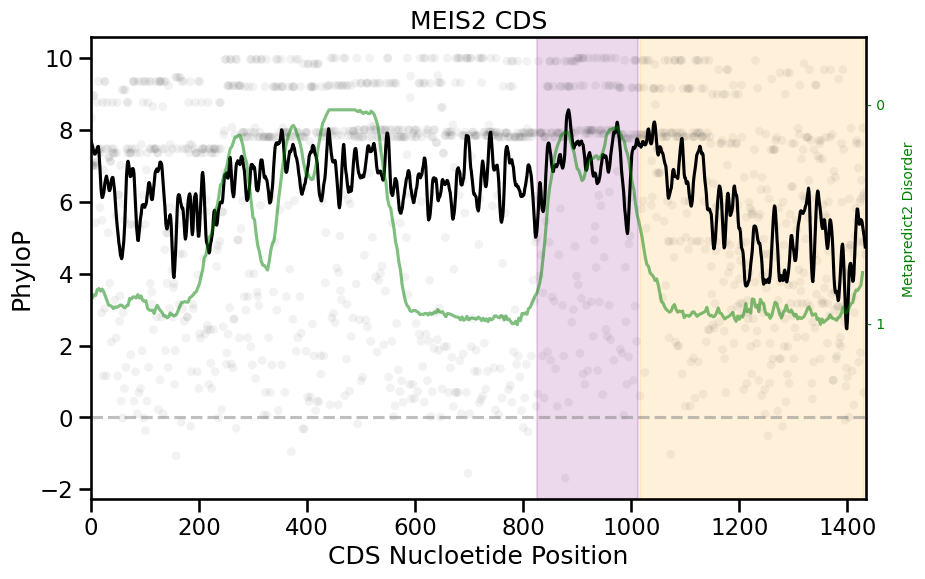

In [147]:
#https://www.geeksforgeeks.org/python-make-a-list-of-intervals-with-sequential-numbers/
def intervals_extract(iterable):
     
    iterable = sorted(set(iterable))
    for key, group in itertools.groupby(enumerate(iterable),
    lambda t: t[1] - t[0]):
        group = list(group)
        yield [group[0][1], group[-1][1]]

    
tfs_tbl = pd.read_csv("../soto_analysis/outputs/TFs_table_proteins.txt", sep = "\t")
for ENST in cc_names.sort_values(by = "ENST")["ENST"].drop_duplicates():
    #display(tfs_tbl[tfs_tbl["ENST"] == ENST])
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    # If negative strand, sort ascending = False
    # Else, sort ascending = True
    if ENST_phylo_P[5].iloc[0] == "-":
        ascending = False
    else: 
        ascending = True
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    domains = pd.read_csv("../soto_analysis/outputs/mutations/domains_100_verteb_15/" + ENST + ".bed", sep = "\t", header = None)
    domains = domains[[0, 1, 2, 3]]
    ENST_phylo_P_with_domains = pd.merge(ENST_phylo_P, domains, how = "left", on = [0, 1, 2])
    ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.fillna(0)
    ENST_phylo_P_with_domains["cds_nt"] = np.arange(len(ENST_phylo_P_with_domains))
    #display(ENST_phylo_P_with_domains)


    # Apply lowess smoothing
    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    
    smoothed = lowess(ENST_phylo_P_with_domains['PhyloP'], ENST_phylo_P_with_domains["cds_nt"], frac=0.01)  # Adjust frac for smoothness
    color_map = {
        'AD': 'orange',
        'DBD': 'purple'
    }
    
    # Create a new DataFrame for smoothed data
    smoothed_df = pd.DataFrame(smoothed, columns=["cds_nt", 'smoothed'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    
    # Create background color blocks based on '3_y'
    for value, color in color_map.items():
        subset = ENST_phylo_P_with_domains[ENST_phylo_P_with_domains['3_y'] == value]
        intervals = list(intervals_extract(subset["cds_nt"]))
        
        for interval in intervals:
            plt.axvspan(interval[0], interval[1], color=color, alpha=0.15)

    sns.scatterplot(data=ENST_phylo_P_with_domains, x="cds_nt", y='PhyloP', color='black', alpha = 0.05, size = 20, legend = False)
    #plt.legend().remove()
    sns.lineplot(data=smoothed_df, x="cds_nt", y='smoothed', color='black')
    plt.xlim(0, max(smoothed_df["cds_nt"]) + 1)
    #extreme = max(np.abs(ENST_phylo_P_with_domains["PhyloP"]))
    #plt.ylim(-1 * extreme - 0.1, extreme + 0.1)

    uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    TF_seq = lambert_TFs[lambert_TFs["uniprotID"] == uniprotID]["ProteinSeq"].iloc[0]
    disorder = np.array(meta.predict_disorder(TF_seq))


    plt.axhline(0, color = "gray", linestyle = "--", alpha = 0.5)
    plt.ylabel("PhyloP", color = "black")
    plt.xlabel('CDS Nucloetide Position')  

    #ax2 = plt.twinx()

    # Normalizing to smoothed
    
    normalized = (disorder - np.mean(disorder)) / np.std(disorder)
    #normalized_to_phyloP = 

    phyloP_min, phyloP_max = min(smoothed_df["smoothed"]), max(smoothed_df["smoothed"])
    inverse_disorder_scaled = (np.array(1 - disorder) * (phyloP_max - phyloP_min)) + phyloP_min
    sns.lineplot(x = np.arange(0, len(disorder) * 3, 3), y = inverse_disorder_scaled, color = "green", alpha = 0.5)

    inv_dis_scal_0 = (0 * (phyloP_max - phyloP_min)) + phyloP_min
    inv_dis_scal_1 = (1 * (phyloP_max - phyloP_min)) + phyloP_min

    plt.text(len(disorder) * 3 + 5, inv_dis_scal_0,'- 1', fontsize=10, color = "green")
    plt.text(len(disorder) * 3 + 5, inv_dis_scal_1,'- 0', fontsize=10, color = "green")
    plt.text(len(disorder) * 3 + 10, (inv_dis_scal_0 + inv_dis_scal_1) / 2,'\n\nMetapredict2 Disorder', verticalalignment = "center", fontsize=10, color = "green", rotation = 90)

    #plt.text(len(disorder) * 3 + 5, np.mean(inv_dis_scal_0, inv_dis_scal_1),'- 0', fontsize=10, color = "green")

    #plt.ylabel("1 - Metapredict2", color = "green")
    #plt.ylim(-1.1, 1.1)

    #plt.ylim(0, 10)
    # Add labels and legend
    #print(ENST)
    plt.title(gene + ' CDS')
    # plt.ylabel('PhyloP Score')
    #plt.legend(title='Domain Type')
    plt.show()


In [148]:
PhyloP = pd.read_csv("../output/cc_15_AD_genes_PhyloP.csv", index_col = 0)
PhyloP = PhyloP.sort_values(by = ['0', '1', '2', '3', 'ENST', '5', '6', '7', '8'])
PhyloP

0         1         2       3             ENST  5   6         7  \
0      2  24658677  24658678  Q15788  ENST00000348332  +   2  24658677   
1      2  24658678  24658679  Q15788  ENST00000348332  +   2  24658678   
2      2  24658679  24658680  Q15788  ENST00000348332  +   2  24658679   
3      2  24658680  24658681  Q15788  ENST00000348332  +   2  24658680   
4      2  24658681  24658682  Q15788  ENST00000348332  +   2  24658681   
...   ..       ...       ...     ...              ... ..  ..       ...   
1435  21  38498375  38498376  P11308  ENST00000288319  -  21  38498375   
1436  21  38498376  38498377  P11308  ENST00000288319  -  21  38498376   
1437  21  38498377  38498378  P11308  ENST00000288319  -  21  38498377   
1438  21  38498378  38498379  P11308  ENST00000288319  -  21  38498378   
1439  21  38498379  38498380  P11308  ENST00000288319  -  21  38498379   

             8  PhyloP  
0     24658678   6.335  
1     24658679   6.360  
2     24658680   8.796  
3     24658681   6.335  
4     24658682   8.796  
...        ...     ...  
1435  38498376   8.796  
1436  38498377   8.903  
1437  38498378   8.903  
1438  38498379   6.335  
1439  38498380   6.360  

[19443 rows x 10 columns]

In [149]:
vertebs = cds_phylo_P.copy(deep = True)
vertebs = vertebs.rename(columns = {"PhyloP":"100_verteb"})
vertebs = vertebs.sort_values(by = [0,1,2,3, 'ENST', 5,6,7,8])
vertebs

0         1         2       3             ENST  5   6         7  \
0      2  24658677  24658678  Q15788  ENST00000348332  +   2  24658677   
1      2  24658678  24658679  Q15788  ENST00000348332  +   2  24658678   
2      2  24658679  24658680  Q15788  ENST00000348332  +   2  24658679   
3      2  24658680  24658681  Q15788  ENST00000348332  +   2  24658680   
4      2  24658681  24658682  Q15788  ENST00000348332  +   2  24658681   
...   ..       ...       ...     ...              ... ..  ..       ...   
1435  21  38498375  38498376  P11308  ENST00000288319  -  21  38498375   
1436  21  38498376  38498377  P11308  ENST00000288319  -  21  38498376   
1437  21  38498377  38498378  P11308  ENST00000288319  -  21  38498377   
1438  21  38498378  38498379  P11308  ENST00000288319  -  21  38498378   
1439  21  38498379  38498380  P11308  ENST00000288319  -  21  38498379   

             8  100_verteb  
0     24658678     8.78601  
1     24658679     7.56435  
2     24658680     9.51900  
3     24658681     8.78601  
4     24658682     9.51900  
...        ...         ...  
1435  38498376     7.87500  
1436  38498377     6.22398  
1437  38498378     6.22398  
1438  38498379     7.25587  
1439  38498380     6.22398  

[19443 rows x 10 columns]

In [150]:
PhyloP["100_verteb"] = vertebs["100_verteb"]
PhyloP

0         1         2       3             ENST  5   6         7  \
0      2  24658677  24658678  Q15788  ENST00000348332  +   2  24658677   
1      2  24658678  24658679  Q15788  ENST00000348332  +   2  24658678   
2      2  24658679  24658680  Q15788  ENST00000348332  +   2  24658679   
3      2  24658680  24658681  Q15788  ENST00000348332  +   2  24658680   
4      2  24658681  24658682  Q15788  ENST00000348332  +   2  24658681   
...   ..       ...       ...     ...              ... ..  ..       ...   
1435  21  38498375  38498376  P11308  ENST00000288319  -  21  38498375   
1436  21  38498376  38498377  P11308  ENST00000288319  -  21  38498376   
1437  21  38498377  38498378  P11308  ENST00000288319  -  21  38498377   
1438  21  38498378  38498379  P11308  ENST00000288319  -  21  38498378   
1439  21  38498379  38498380  P11308  ENST00000288319  -  21  38498379   

             8  PhyloP  100_verteb  
0     24658678   6.335     8.78601  
1     24658679   6.360     7.56435  
2     24658680   8.796     9.51900  
3     24658681   6.335     8.78601  
4     24658682   8.796     9.51900  
...        ...     ...         ...  
1435  38498376   8.796     7.87500  
1436  38498377   8.903     6.22398  
1437  38498378   8.903     6.22398  
1438  38498379   6.335     7.25587  
1439  38498380   6.360     6.22398  

[19443 rows x 11 columns]

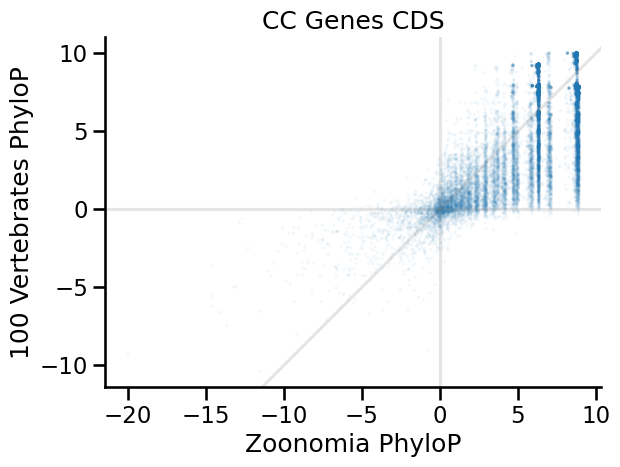

In [251]:
from matplotlib import rcParams

#plt.figure(figsize = (4,4), dpi = 300)
#rcParams.update({'font.size': 12})

plt.xlabel("Zoonomia PhyloP")
plt.ylabel("100 Vertebrates PhyloP")
plt.axvline(0, color = "gray", alpha = 0.2)
plt.axhline(0, color = "gray", alpha = 0.2)
plt.axline((0, 0), slope=1, color = "gray", alpha = 0.2)
plt.gca().set_aspect('equal', adjustable='box')

sns.scatterplot(data = PhyloP, x = "PhyloP", y = "100_verteb", alpha = 0.05, s = 5, legend = None, edgecolor = "none")
sns.despine()
plt.title("CC Genes CDS");

In [152]:
AD_variances = []
DBD_variances = []
ENSTs = []

for ENST in set(cc_names["ENST"]):
    ENSTs.append(ENST)
    AD_rows = ad_phylo_P[ad_phylo_P[7] == ENST]["PhyloP"]
    DBD_rows = dbd_phylo_P[dbd_phylo_P[7] == ENST]["PhyloP"]

    AD_variances.append(np.var(AD_rows))
    DBD_variances.append(np.var(DBD_rows))

variance_df = pd.DataFrame({"ENST" : ENSTs, "AD" : AD_variances, "DBD" : DBD_variances})
variance_df

ENST         AD        DBD
0   ENST00000331340  11.218664        NaN
1   ENST00000282549  10.905720  12.526572
2   ENST00000241001   9.978800   9.786373
3   ENST00000339562   8.706201  12.599636
4   ENST00000358127  12.143132  12.618585
5   ENST00000265340  10.637297  10.417279
6   ENST00000348066   6.593167  11.078491
7   ENST00000377142   6.963047  12.538580
8   ENST00000348332   8.931614        NaN
9   ENST00000288319  10.957586  13.348446
10  ENST00000561208   7.607328   8.764513

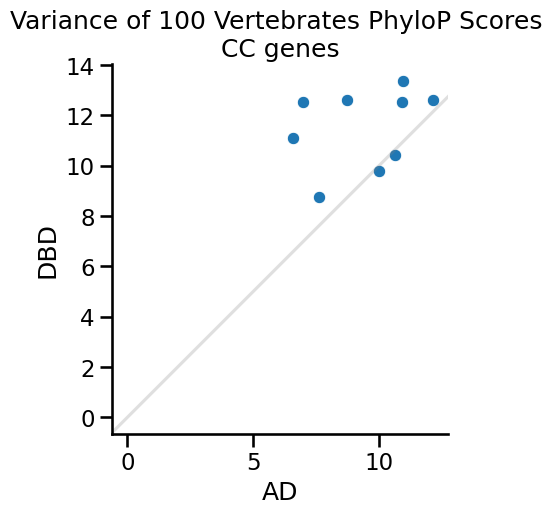

In [153]:
plt.style.use("default")
sns.set_context('talk')
plt.gca().set_aspect('equal', adjustable='box')

plt.axline((0, 0), slope=1, color = "gray", alpha = 0.25)
sns.scatterplot(data = variance_df, x = "AD", y = "DBD")
sns.despine()
plt.title("Variance of 100 Vertebrates PhyloP Scores \nCC genes");

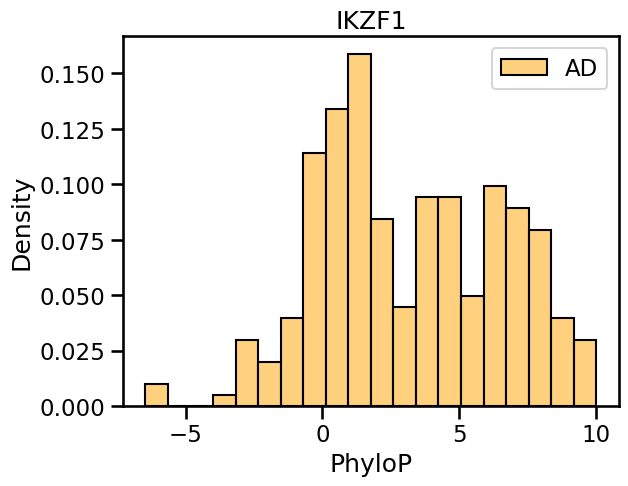

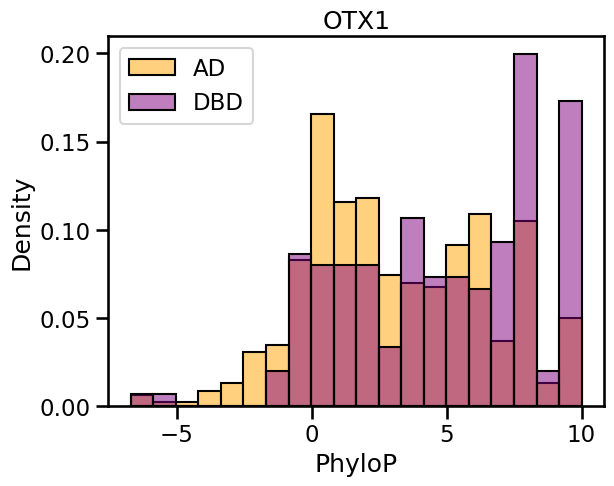

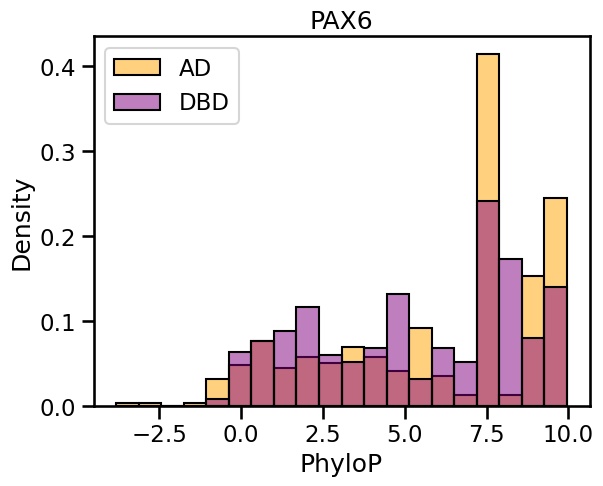

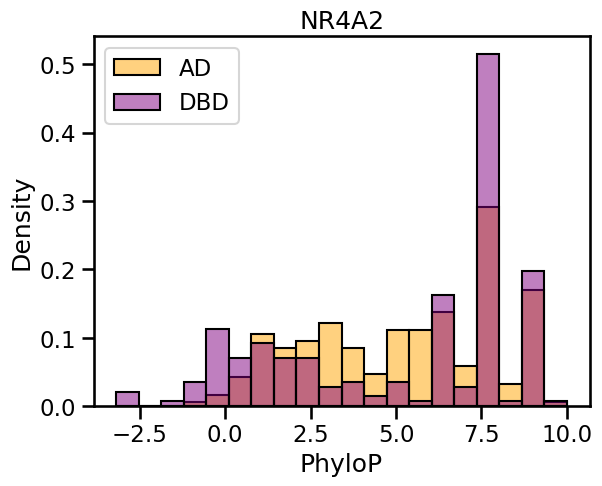

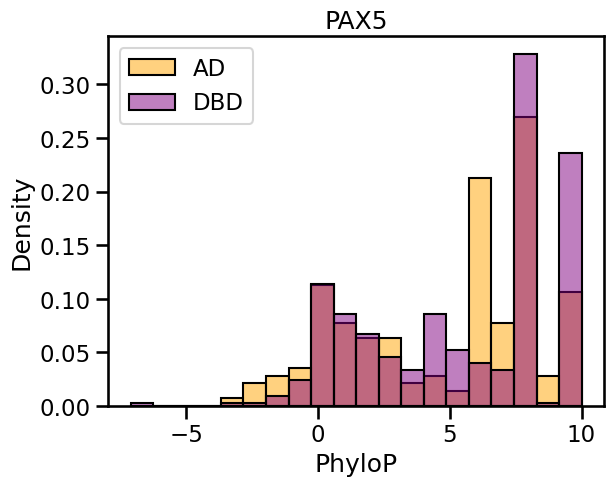

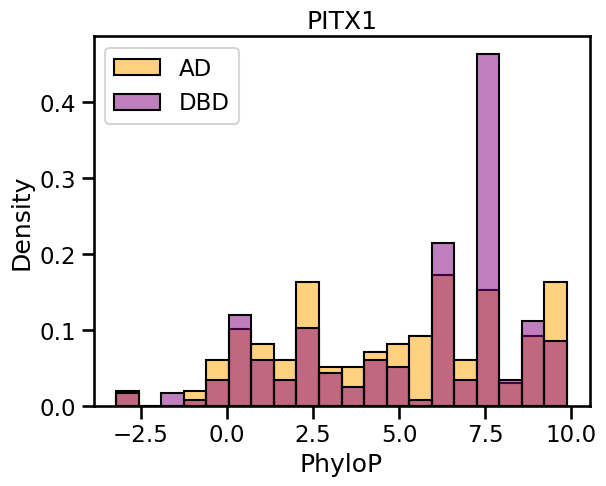

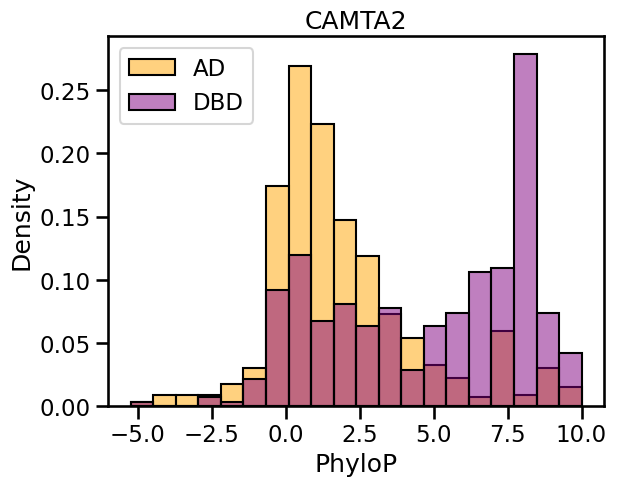

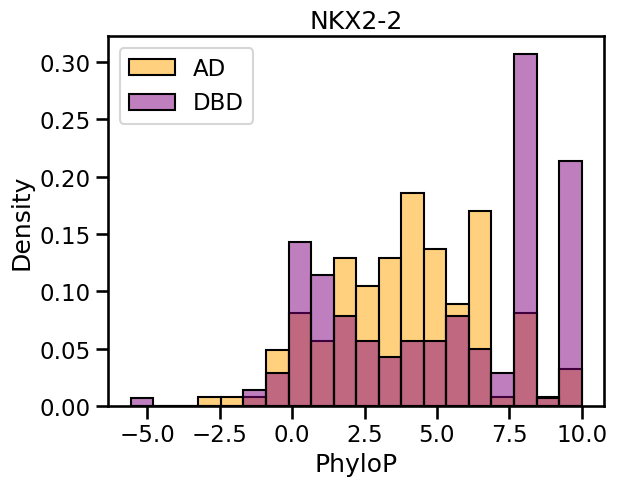

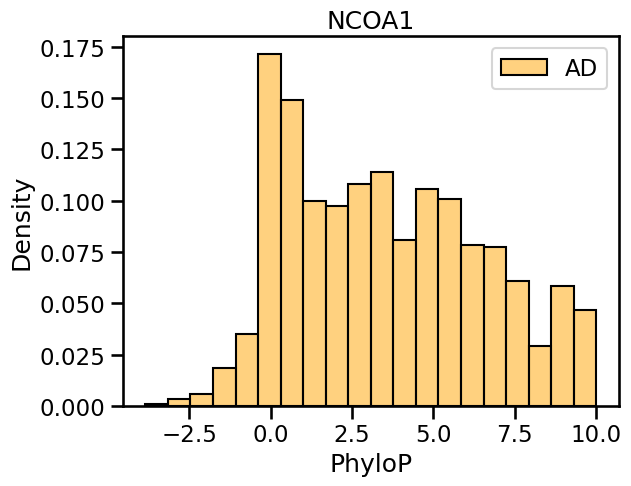

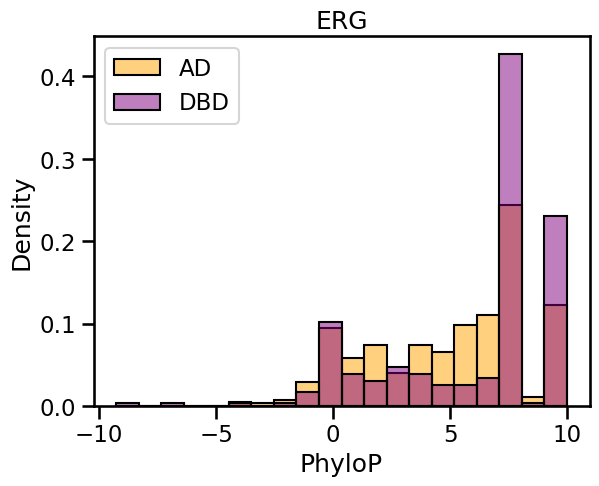

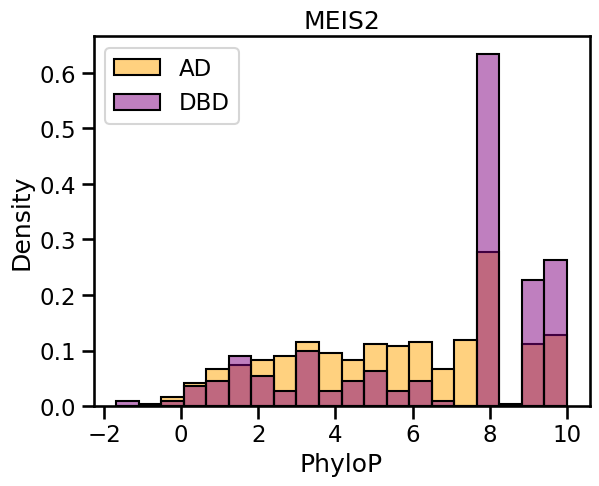

In [154]:
for ENST in set(cc_names["ENST"]):
    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    AD_rows = ad_phylo_P[ad_phylo_P[7] == ENST]["PhyloP"]
    DBD_rows = dbd_phylo_P[dbd_phylo_P[7] == ENST]["PhyloP"]

    if len(AD_rows) > 0 and len(DBD_rows) > 0:
        min_both = min(min(AD_rows), min(DBD_rows))
        max_both = max(max(AD_rows), max(DBD_rows)) 
        step = (max_both - min_both) / 20
        bins = np.arange(min_both, max_both + step, step)
    else:
        step = (max(AD_rows) - min(AD_rows)) / 20
        bins = np.arange(min(AD_rows), max(AD_rows) + step, step) 
    sns.histplot(AD_rows, label = "AD", stat = "density", bins = bins, color = "orange", alpha = 0.5)
    sns.histplot(DBD_rows, label = "DBD", stat = "density", bins = bins, color = "purple", alpha = 0.5)
    plt.title(gene)
    plt.legend()
    plt.show();

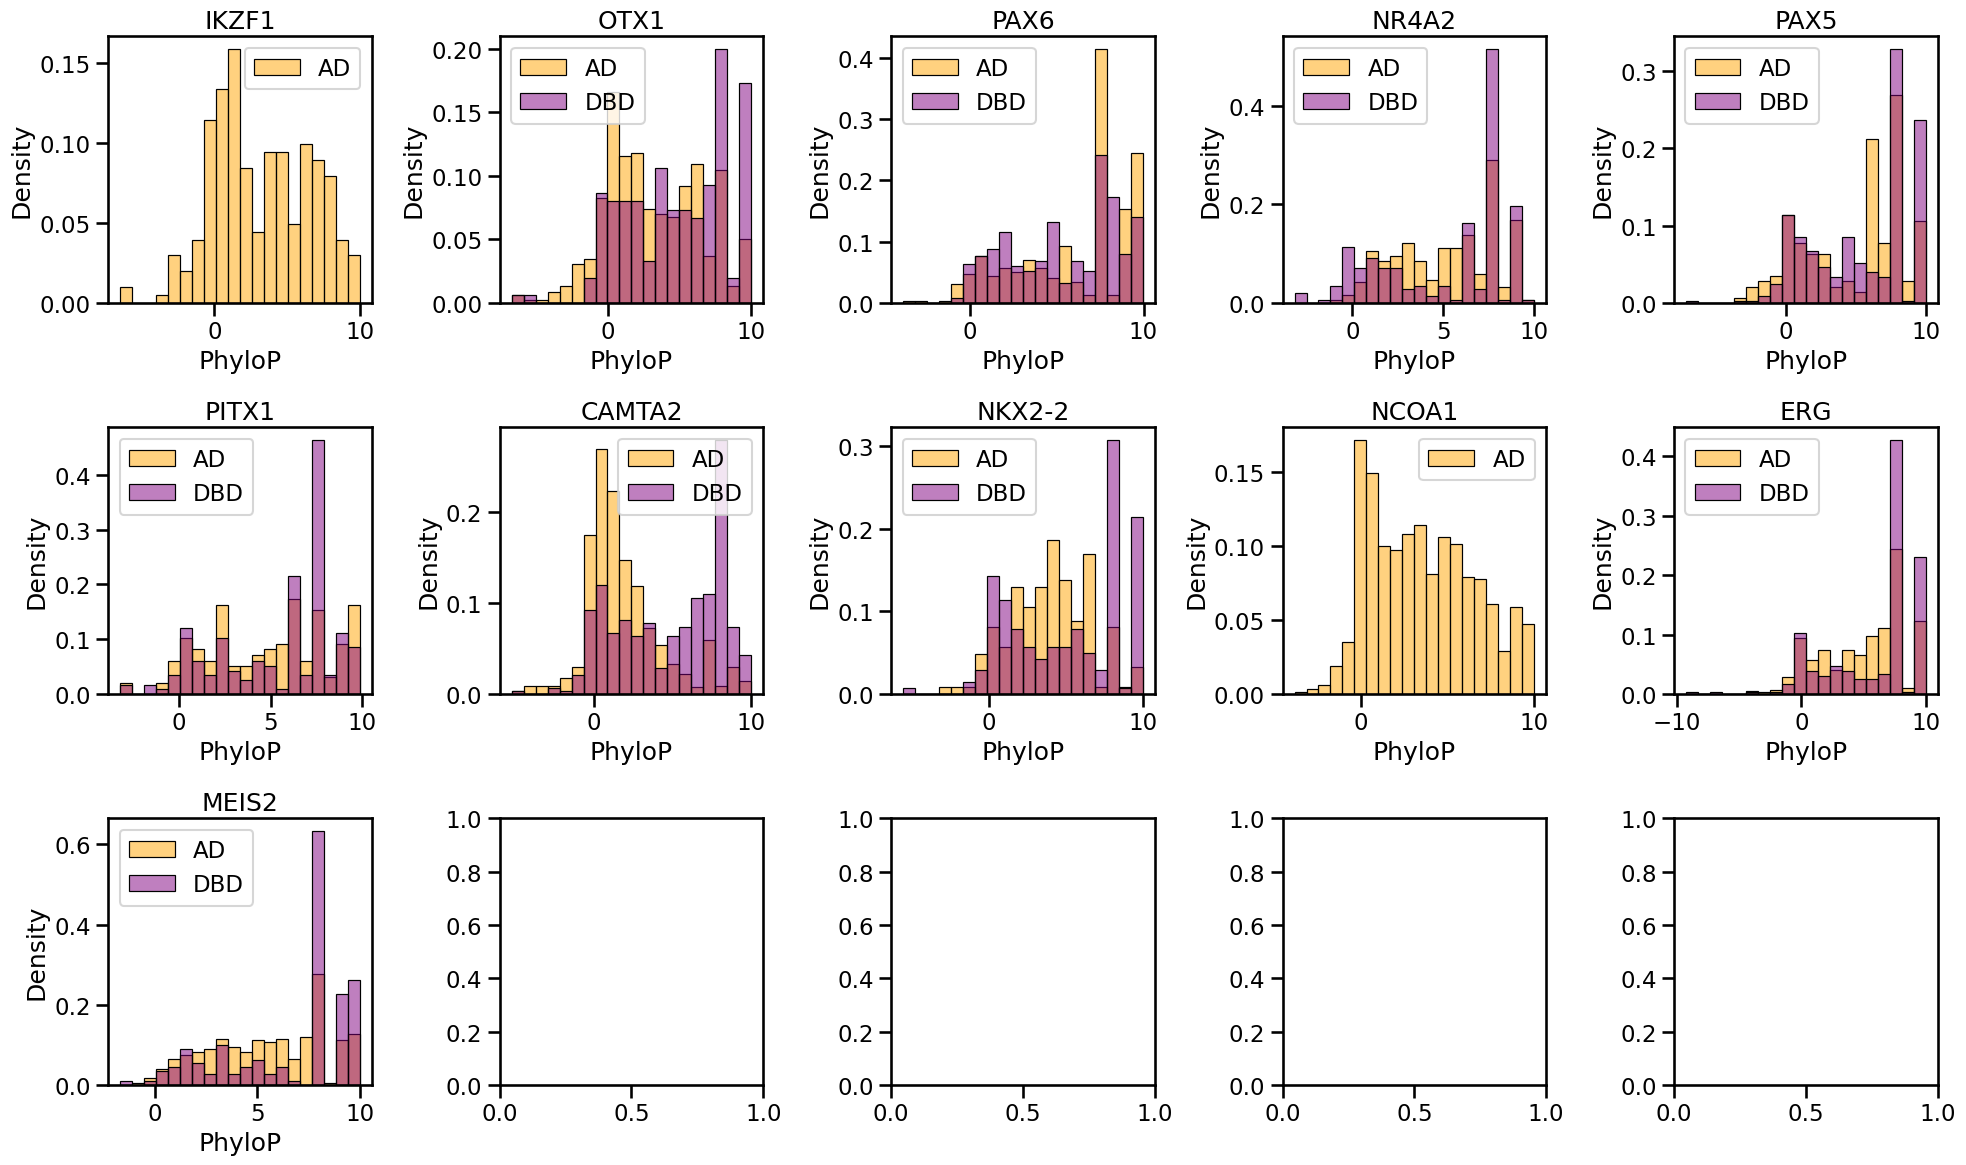

In [155]:
# Create a figure with 3 rows and 5 columns for subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes

# Loop through ENST entries and create histograms
for idx, ENST in enumerate(set(cc_names["ENST"])):
    if idx >= 15:  # Limit to 15 plots (3 rows * 5 columns)
        break

    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    AD_rows = ad_phylo_P[ad_phylo_P[7] == ENST]["PhyloP"]
    DBD_rows = dbd_phylo_P[dbd_phylo_P[7] == ENST]["PhyloP"]

    if len(AD_rows) > 0 and len(DBD_rows) > 0:
        min_both = min(min(AD_rows), min(DBD_rows))
        max_both = max(max(AD_rows), max(DBD_rows))
        step = (max_both - min_both) / 20
        bins = np.arange(min_both, max_both + step, step)
    else:
        step = (max(AD_rows) - min(AD_rows)) / 20
        bins = np.arange(min(AD_rows), max(AD_rows) + step, step)
    
    ax = axes[idx]
    sns.histplot(AD_rows, label="AD", stat="density", bins=bins, color="orange", alpha=0.5, ax=ax)
    sns.histplot(DBD_rows, label="DBD", stat="density", bins=bins, color="purple", alpha=0.5, ax=ax)
    
    ax.set_title(gene)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PNG file

# Show the figure (optional)
plt.show()


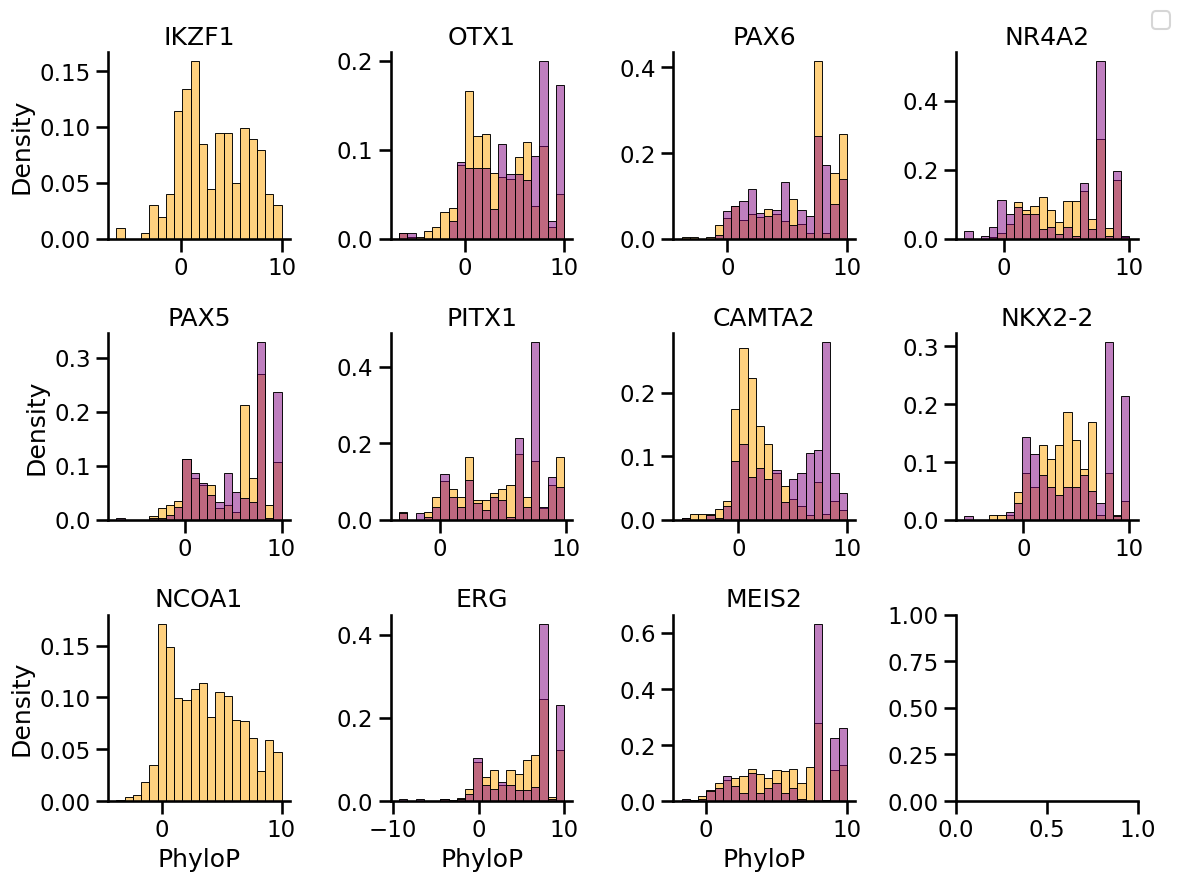

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with 3 rows and 4 columns for subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes

# Loop through ENST entries and create histograms
for idx, ENST in enumerate(set(cc_names["ENST"])):
    if idx >= 11:  # Limit to 11 plots (3 rows * 4 columns, with 1 empty)
        break

    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    AD_rows = ad_phylo_P[ad_phylo_P[7] == ENST]["PhyloP"]
    DBD_rows = dbd_phylo_P[dbd_phylo_P[7] == ENST]["PhyloP"]

    if len(AD_rows) > 0 and len(DBD_rows) > 0:
        min_both = min(min(AD_rows), min(DBD_rows))
        max_both = max(max(AD_rows), max(DBD_rows))
        step = (max_both - min_both) / 20
        bins = np.arange(min_both, max_both + step, step)
    else:
        step = (max(AD_rows) - min(AD_rows)) / 20
        bins = np.arange(min(AD_rows), max(AD_rows) + step, step)

    ax = axes[idx]
    sns.histplot(AD_rows, stat="density", bins=bins, color="orange", alpha=0.5, ax=ax)
    sns.histplot(DBD_rows, stat="density", bins=bins, color="purple", alpha=0.5, ax=ax)
    sns.despine()
    
    if idx %4 == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")

    if idx < 8:
        ax.set_xlabel("")

      
    ax.set_title(gene)

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, ['AD', 'DBD'], loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PNG file
#plt.savefig("100_verteb_cc_15_phyloP_histograms.png")

# Show the figure (optional)
plt.show()


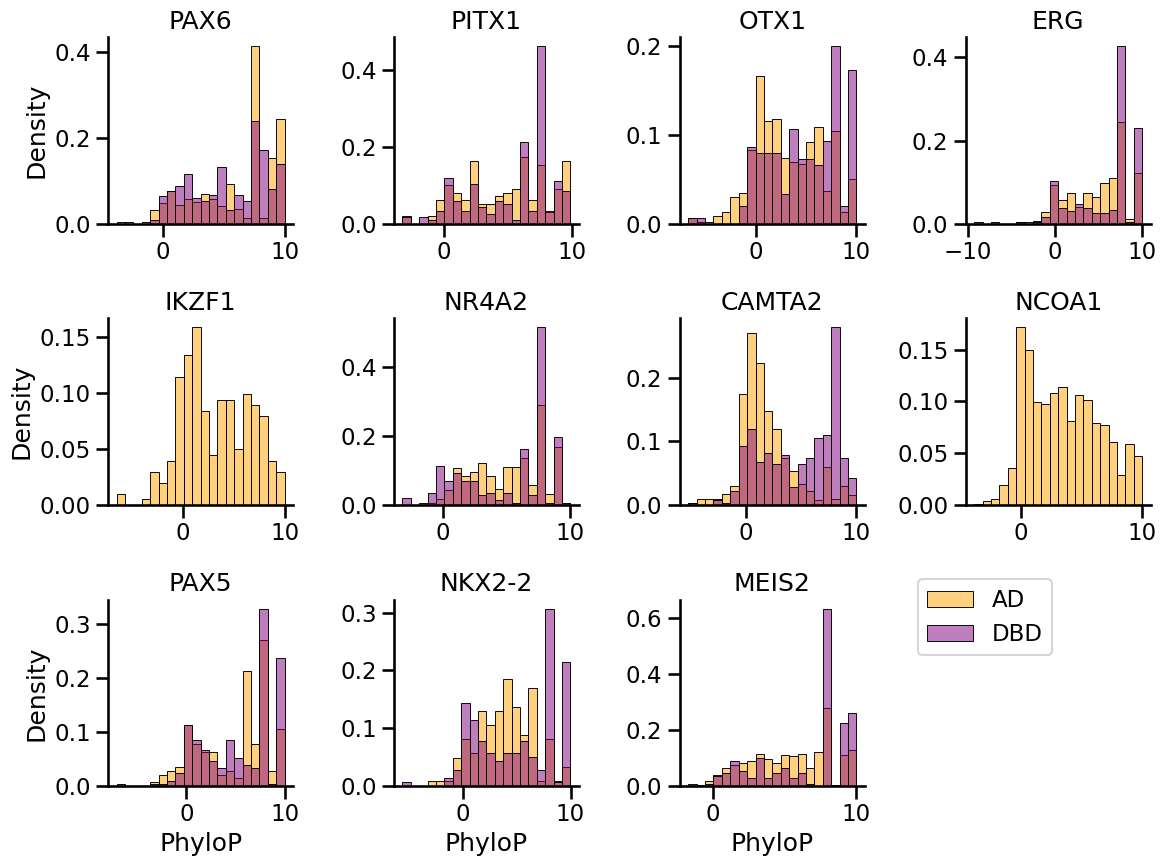

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with 3 rows and 4 columns for subplots
fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes

# Initialize variables to store handles and labels for the legend
handles = []
labels = []

# Loop through ENST entries and create histograms
for idx, ENST in enumerate(cc_names.sort_values(by = "ENST")["ENST"].drop_duplicates()):
    if idx >= 11:  # Limit to 11 plots (3 rows * 4 columns, with 1 empty)
        break

    gene = cc_names[cc_names["ENST"] == ENST]["Gene"].iloc[0]
    AD_rows = ad_phylo_P[ad_phylo_P[7] == ENST]["PhyloP"]
    DBD_rows = dbd_phylo_P[dbd_phylo_P[7] == ENST]["PhyloP"]

    if len(AD_rows) > 0 and len(DBD_rows) > 0:
        min_both = min(min(AD_rows), min(DBD_rows))
        max_both = max(max(AD_rows), max(DBD_rows))
        step = (max_both - min_both) / 20
        bins = np.arange(min_both, max_both + step, step)
    else:
        step = (max(AD_rows) - min(AD_rows)) / 20
        bins = np.arange(min(AD_rows), max(AD_rows) + step, step)

    ax = axes[idx]
    ad_plot = sns.histplot(AD_rows, stat="density", bins=bins, color="orange", alpha=0.5, ax=ax, label="AD")
    dbd_plot = sns.histplot(DBD_rows, stat="density", bins=bins, color="purple", alpha=0.5, ax=ax, label="DBD")
    
    sns.despine()

    if idx % 4 == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")

    if idx < 8:
        ax.set_xlabel("")

    ax.set_title(gene)

    # Collect legend handles and labels from the second subplot
    if idx == 1:
        handles, labels = ax.get_legend_handles_labels()

# Create a single legend for the entire figure using the collected handles and labels
fig.legend(handles, labels, bbox_to_anchor = (0, 0, 0.9,0.35))
fig.delaxes(axes[11])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


In [217]:
ad_phylo_P["0"] = ad_phylo_P[0]
ad_phylo_P["1"] = ad_phylo_P[1]
ad_phylo_P["2"] = ad_phylo_P[2]
ad_phylo_P["100_verteb"] = ad_phylo_P["PhyloP"]
ad_phylo_P

0         1         2   3             ENST  5  6                7   8  \
0      7  50376792  50376793  AD  ENSG00000185811  .  +  ENST00000331340   7   
1      7  50399917  50399918  AD  ENSG00000185811  .  +  ENST00000331340   7   
2      7  50399918  50399919  AD  ENSG00000185811  .  +  ENST00000331340   7   
3      7  50399919  50399920  AD  ENSG00000185811  .  +  ENST00000331340   7   
4      7  50399920  50399921  AD  ENSG00000185811  .  +  ENST00000331340   7   
...   ..       ...       ...  ..              ... .. ..              ...  ..   
5140  15  36896641  36896642  AD  ENSG00000134138  .  -  ENST00000561208  15   
5141  15  36896642  36896643  AD  ENSG00000134138  .  -  ENST00000561208  15   
5142  15  36896643  36896644  AD  ENSG00000134138  .  -  ENST00000561208  15   
5143  15  36896644  36896645  AD  ENSG00000134138  .  -  ENST00000561208  15   
5144  15  36896645  36896646  AD  ENSG00000134138  .  -  ENST00000561208  15   

             9  ...  13  14        15        16   PhyloP          id   0  \
0     50376792  ...   +   7  50376792  50376793  9.99200   750376792   7   
1     50399917  ...   +   7  50399917  50399918  9.67770   750399917   7   
2     50399918  ...   +   7  50399918  50399919  1.41213   750399918   7   
3     50399919  ...   +   7  50399919  50399920  9.67770   750399919   7   
4     50399920  ...   +   7  50399920  50399921  9.03195   750399920   7   
...        ...  ...  ..  ..       ...       ...      ...         ...  ..   
5140  36896641  ...   -  15  36896641  36896642  7.87603  1536896641  15   
5141  36896642  ...   -  15  36896642  36896643  9.94000  1536896642  15   
5142  36896643  ...   -  15  36896643  36896644  5.81206  1536896643  15   
5143  36896644  ...   -  15  36896644  36896645  7.87603  1536896644  15   
5144  36896645  ...   -  15  36896645  36896646  7.76740  1536896645  15   

             1         2  100_verteb  
0     50376792  50376793     9.99200  
1     50399917  50399918     9.67770  
2     50399918  50399919     1.41213  
3     50399919  50399920     9.67770  
4     50399920  50399921     9.03195  
...        ...       ...         ...  
5140  36896641  36896642     7.87603  
5141  36896642  36896643     9.94000  
5142  36896643  36896644     5.81206  
5143  36896644  36896645     7.87603  
5144  36896645  36896646     7.76740  

[5145 rows x 23 columns]

In [215]:
PhyloP

0         1         2       3             ENST  5   6         7  \
0      2  24658677  24658678  Q15788  ENST00000348332  +   2  24658677   
1      2  24658678  24658679  Q15788  ENST00000348332  +   2  24658678   
2      2  24658679  24658680  Q15788  ENST00000348332  +   2  24658679   
3      2  24658680  24658681  Q15788  ENST00000348332  +   2  24658680   
4      2  24658681  24658682  Q15788  ENST00000348332  +   2  24658681   
...   ..       ...       ...     ...              ... ..  ..       ...   
1435  21  38498375  38498376  P11308  ENST00000288319  -  21  38498375   
1436  21  38498376  38498377  P11308  ENST00000288319  -  21  38498376   
1437  21  38498377  38498378  P11308  ENST00000288319  -  21  38498377   
1438  21  38498378  38498379  P11308  ENST00000288319  -  21  38498378   
1439  21  38498379  38498380  P11308  ENST00000288319  -  21  38498379   

             8  PhyloP  100_verteb  
0     24658678   6.335     8.78601  
1     24658679   6.360     7.56435  
2     24658680   8.796     9.51900  
3     24658681   6.335     8.78601  
4     24658682   8.796     9.51900  
...        ...     ...         ...  
1435  38498376   8.796     7.87500  
1436  38498377   8.903     6.22398  
1437  38498378   8.903     6.22398  
1438  38498379   6.335     7.25587  
1439  38498380   6.360     6.22398  

[19443 rows x 11 columns]

In [222]:
ad_both_PhyloP = pd.merge(PhyloP, ad_phylo_P[["0", "1", "2", "100_verteb"]], on = ["0", "1", "2", "100_verteb"])
ad_both_PhyloP

0         1         2       3             ENST  5   6         7  \
0      2  24658677  24658678  Q15788  ENST00000348332  +   2  24658677   
1      2  24658678  24658679  Q15788  ENST00000348332  +   2  24658678   
2      2  24658679  24658680  Q15788  ENST00000348332  +   2  24658679   
3      2  24658680  24658681  Q15788  ENST00000348332  +   2  24658680   
4      2  24658681  24658682  Q15788  ENST00000348332  +   2  24658681   
...   ..       ...       ...     ...              ... ..  ..       ...   
5140  21  38423441  38423442  P11308  ENST00000288319  -  21  38423441   
5141  21  38423442  38423443  P11308  ENST00000288319  -  21  38423442   
5142  21  38423443  38423444  P11308  ENST00000288319  -  21  38423443   
5143  21  38423444  38423445  P11308  ENST00000288319  -  21  38423444   
5144  21  38423445  38423446  P11308  ENST00000288319  -  21  38423445   

             8  PhyloP  100_verteb  
0     24658678   6.335     8.78601  
1     24658679   6.360     7.56435  
2     24658680   8.796     9.51900  
3     24658681   6.335     8.78601  
4     24658682   8.796     9.51900  
...        ...     ...         ...  
5140  38423442   6.873     9.60200  
5141  38423443   4.643     5.91548  
5142  38423444   6.961     7.49542  
5143  38423445   6.227     8.94369  
5144  38423446   4.643     7.62708  

[5145 rows x 11 columns]

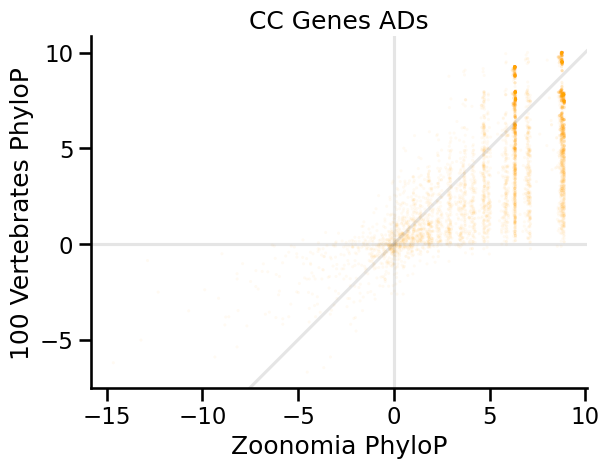

In [250]:

#plt.figure(figsize = (4,4), dpi = 300)
#rcParams.update({'font.size': 12})

plt.xlabel("Zoonomia PhyloP")
plt.ylabel("100 Vertebrates PhyloP")
plt.axvline(0, color = "gray", alpha = 0.2)
plt.axhline(0, color = "gray", alpha = 0.2)
plt.axline((0, 0), slope=1, color = "gray", alpha = 0.2)
plt.gca().set_aspect('equal', adjustable='box')

sns.scatterplot(data = ad_both_PhyloP, x = "PhyloP", y = "100_verteb", alpha = 0.05, s = 5, legend = None, edgecolor = "none", color = "orange")
sns.despine()
plt.title("CC Genes ADs");

In [224]:
dbd_phylo_P["0"] = dbd_phylo_P[0]
dbd_phylo_P["1"] = dbd_phylo_P[1]
dbd_phylo_P["2"] = dbd_phylo_P[2]
dbd_phylo_P["100_verteb"] = dbd_phylo_P["PhyloP"]
dbd_phylo_P

0         1         2    3             ENST  5  6                7   8  \
0     2  63054060  63054061  DBD  ENSG00000115507  .  +  ENST00000282549   2   
1     2  63054061  63054062  DBD  ENSG00000115507  .  +  ENST00000282549   2   
2     2  63054062  63054063  DBD  ENSG00000115507  .  +  ENST00000282549   2   
3     2  63054063  63054064  DBD  ENSG00000115507  .  +  ENST00000282549   2   
4     2  63054064  63054065  DBD  ENSG00000115507  .  +  ENST00000282549   2   
..   ..       ...       ...  ...              ... .. ..              ...  ..   
184  15  37036883  37036884  DBD  ENSG00000134138  .  -  ENST00000561208  15   
185  15  37036884  37036885  DBD  ENSG00000134138  .  -  ENST00000561208  15   
186  15  37036885  37036886  DBD  ENSG00000134138  .  -  ENST00000561208  15   
187  15  37036886  37036887  DBD  ENSG00000134138  .  -  ENST00000561208  15   
188  15  37036887  37036888  DBD  ENSG00000134138  .  -  ENST00000561208  15   

            9  ...               12 13  14        15        16    PhyloP   0  \
0    63054060  ...  ENST00000282549  +   2  63054060  63054061  6.076740   2   
1    63054061  ...  ENST00000282549  +   2  63054061  63054062  9.213750   2   
2    63054062  ...  ENST00000282549  +   2  63054062  63054063  9.998000   2   
3    63054063  ...  ENST00000282549  +   2  63054063  63054064  2.024770   2   
4    63054064  ...  ENST00000282549  +   2  63054064  63054065  9.998000   2   
..        ...  ...              ... ..  ..       ...       ...       ...  ..   
184  37036883  ...  ENST00000561208  -  15  37036883  37036884  7.923980  15   
185  37036884  ...  ENST00000561208  -  15  37036884  37036885  9.917000  15   
186  37036885  ...  ENST00000561208  -  15  37036885  37036886  0.655339  15   
187  37036886  ...  ENST00000561208  -  15  37036886  37036887  6.048200  15   
188  37036887  ...  ENST00000561208  -  15  37036887  37036888  4.993080  15   

            1         2  100_verteb  
0    63054060  63054061    6.076740  
1    63054061  63054062    9.213750  
2    63054062  63054063    9.998000  
3    63054063  63054064    2.024770  
4    63054064  63054065    9.998000  
..        ...       ...         ...  
184  37036883  37036884    7.923980  
185  37036884  37036885    9.917000  
186  37036885  37036886    0.655339  
187  37036886  37036887    6.048200  
188  37036887  37036888    4.993080  

[2340 rows x 22 columns]

In [225]:
dbd_both_PhyloP = pd.merge(PhyloP, dbd_phylo_P[["0", "1", "2", "100_verteb"]], on = ["0", "1", "2", "100_verteb"])
dbd_both_PhyloP

0         1         2       3             ENST  5   6         7  \
0      2  63054060  63054061  P32242  ENST00000282549  +   2  63054060   
1      2  63054061  63054062  P32242  ENST00000282549  +   2  63054061   
2      2  63054062  63054063  P32242  ENST00000282549  +   2  63054062   
3      2  63054063  63054064  P32242  ENST00000282549  +   2  63054063   
4      2  63054064  63054065  P32242  ENST00000282549  +   2  63054064   
...   ..       ...       ...     ...              ... ..  ..       ...   
2335  21  38383907  38383908  P11308  ENST00000288319  -  21  38383907   
2336  21  38383908  38383909  P11308  ENST00000288319  -  21  38383908   
2337  21  38383909  38383910  P11308  ENST00000288319  -  21  38383909   
2338  21  38383910  38383911  P11308  ENST00000288319  -  21  38383910   
2339  21  38383911  38383912  P11308  ENST00000288319  -  21  38383911   

             8  PhyloP  100_verteb  
0     63054061   8.899     6.07674  
1     63054062   6.332     9.21375  
2     63054063   7.027     9.99800  
3     63054064   2.899     2.02477  
4     63054065   8.792     9.99800  
...        ...     ...         ...  
2335  38383908   6.173     7.87743  
2336  38383909   8.530    10.00300  
2337  38383910   1.169     0.58974  
2338  38383911   6.148     9.24387  
2339  38383912   6.173     7.87743  

[2340 rows x 11 columns]

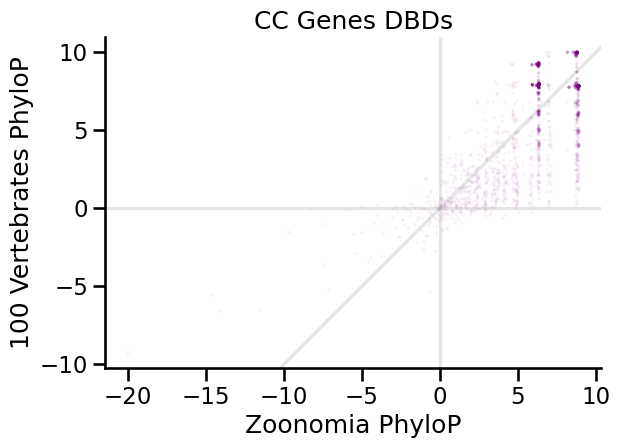

In [248]:

#plt.figure(figsize = (4,4), dpi = 300)
#rcParams.update({'font.size': 12})

plt.xlabel("Zoonomia PhyloP")
plt.ylabel("100 Vertebrates PhyloP")
plt.axvline(0, color = "gray", alpha = 0.2)
plt.axhline(0, color = "gray", alpha = 0.2)
plt.axline((0, 0), slope=1, color = "gray", alpha = 0.2)
plt.gca().set_aspect('equal', adjustable='box')

sns.scatterplot(data = dbd_both_PhyloP, x = "PhyloP", y = "100_verteb", alpha = 0.05, s = 5, legend = None, edgecolor = "none", color = "purple")
sns.despine()
plt.title("CC Genes DBDs");

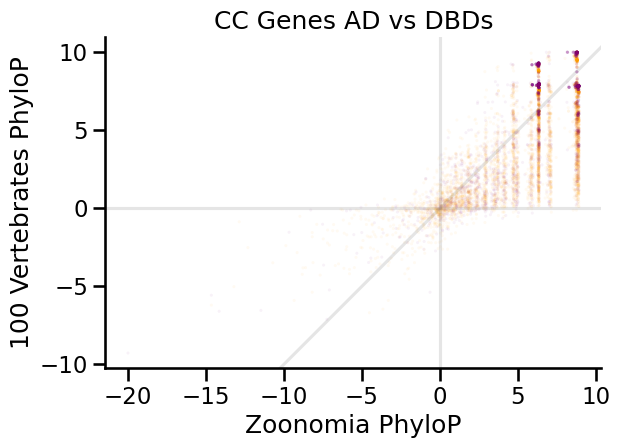

In [249]:

#plt.figure(figsize = (4,4), dpi = 300)
#rcParams.update({'font.size': 12})

plt.xlabel("Zoonomia PhyloP")
plt.ylabel("100 Vertebrates PhyloP")
plt.axvline(0, color = "gray", alpha = 0.2)
plt.axhline(0, color = "gray", alpha = 0.2)
plt.axline((0, 0), slope=1, color = "gray", alpha = 0.2)
plt.gca().set_aspect('equal', adjustable='box')

sns.scatterplot(data = ad_both_PhyloP, x = "PhyloP", y = "100_verteb", alpha = 0.05, s = 5, legend = True, edgecolor = "none", color = "orange")
sns.scatterplot(data = dbd_both_PhyloP, x = "PhyloP", y = "100_verteb", alpha = 0.05, s = 5, legend = True, edgecolor = "none", color = "purple")

sns.despine()
plt.title("CC Genes AD vs DBDs");

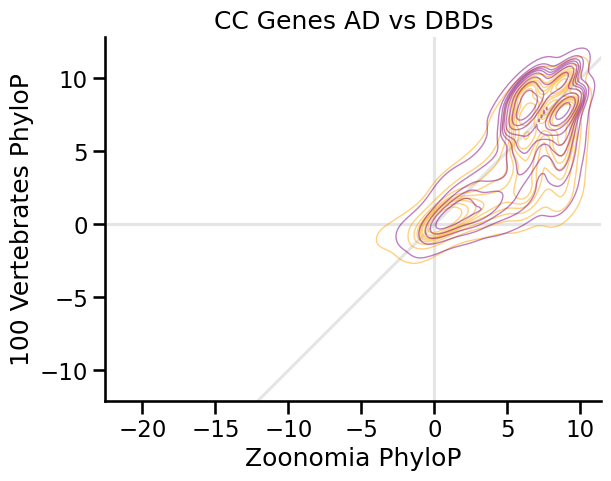

In [258]:

#plt.figure(figsize = (4,4), dpi = 300)
#rcParams.update({'font.size': 12})

plt.xlabel("Zoonomia PhyloP")
plt.ylabel("100 Vertebrates PhyloP")
plt.axvline(0, color = "gray", alpha = 0.2)
plt.axhline(0, color = "gray", alpha = 0.2)
plt.axline((0, 0), slope=1, color = "gray", alpha = 0.2)
plt.gca().set_aspect('equal', adjustable='box')

sns.kdeplot(data = ad_both_PhyloP, x = "PhyloP", y = "100_verteb", alpha = 0.5, linewidths = 1, legend = True, edgecolor = "none", color = "orange")
sns.kdeplot(data = dbd_both_PhyloP, x = "PhyloP", y = "100_verteb", alpha = 0.5, linewidths = 1, legend = True, edgecolor = "none", color = "purple")

sns.despine()
plt.title("CC Genes AD vs DBDs");

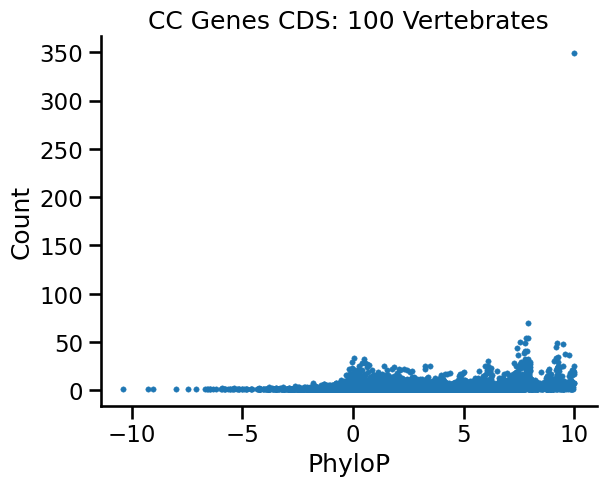

In [266]:
PhyloP_vs_count = pd.DataFrame(cds_phylo_P['PhyloP'].value_counts().reset_index())
sns.scatterplot(data = PhyloP_vs_count, x = "PhyloP", y = "count", edgecolor = None, s = 15)
plt.title("CC Genes CDS: 100 Vertebrates")
plt.ylabel("Count")
sns.despine();

In [267]:
cds_phylo_P

0         1         2       3             ENST  5   6         7  \
0      7  50319061  50319062  Q13422  ENST00000331340  +   7  50319061   
1      7  50319062  50319063  Q13422  ENST00000331340  +   7  50319062   
2      7  50319063  50319064  Q13422  ENST00000331340  +   7  50319063   
3      7  50319064  50319065  Q13422  ENST00000331340  +   7  50319064   
4      7  50319065  50319066  Q13422  ENST00000331340  +   7  50319065   
...   ..       ...       ...     ...              ... ..  ..       ...   
1429  15  37099461  37099462  O14770  ENST00000561208  -  15  37099461   
1430  15  37099462  37099463  O14770  ENST00000561208  -  15  37099462   
1431  15  37099463  37099464  O14770  ENST00000561208  -  15  37099463   
1432  15  37099464  37099465  O14770  ENST00000561208  -  15  37099464   
1433  15  37099465  37099466  O14770  ENST00000561208  -  15  37099465   

             8   PhyloP  
0     50319062  8.06732  
1     50319063  6.83065  
2     50319064  8.62945  
3     50319065  6.83065  
4     50319066  8.06732  
...        ...      ...  
1429  37099462  8.95900  
1430  37099463  7.00776  
1431  37099464  7.00776  
1432  37099465  8.33815  
1433  37099466  7.09645  

[19443 rows x 10 columns]

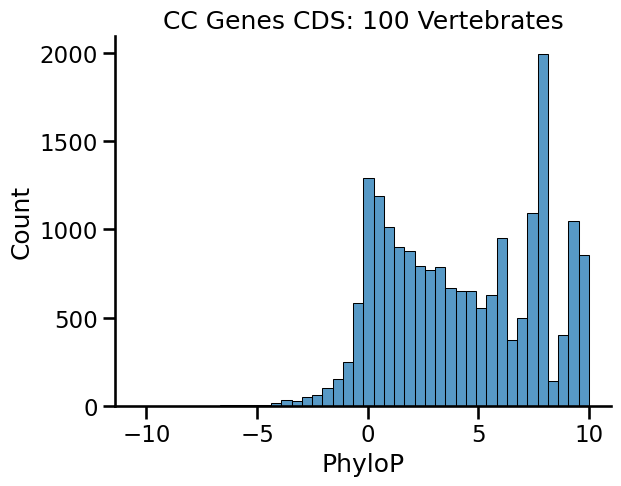

In [268]:
sns.histplot(data = cds_phylo_P, x = "PhyloP")
plt.title("CC Genes CDS: 100 Vertebrates")
plt.ylabel("Count")
sns.despine();